# Análisis exploratorio de los datos

In [1]:
# Importar librería para cargar datos procesados
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import warnings

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

In [3]:
# Cargar los datos procesados
df = pd.read_parquet('../../data/processed/COVID19MEXICO_Processed.parquet')

# Inspeccionar las primeras filas de los datos procesados
df.head()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,DEFUNCION,AÑO_ACTUALIZACION,MES_ACTUALIZACION,DIA_ACTUALIZACION,AÑO_INGRESO,MES_INGRESO,DIA_INGRESO,AÑO_SINTOMAS,MES_SINTOMAS,DIA_SINTOMAS
0,2,12,9,2,9,9,9,1,-2,2,...,2,2024,4,23,2023,2,26,2023,2,22
1,2,6,5,1,5,5,28,1,-2,2,...,2,2024,4,23,2023,3,24,2023,3,19
2,1,12,9,1,9,9,12,1,-2,2,...,2,2024,4,23,2023,3,2,2023,3,1
3,2,12,16,2,16,16,41,1,-2,2,...,2,2024,4,23,2023,3,9,2023,3,6
4,2,12,3,1,15,3,3,1,-2,2,...,2,2024,4,23,2023,6,12,2023,6,9


In [4]:
df.columns

Index(['ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES',
       'MUNICIPIO_RES', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'DEFUNCION',
       'AÑO_ACTUALIZACION', 'MES_ACTUALIZACION', 'DIA_ACTUALIZACION',
       'AÑO_INGRESO', 'MES_INGRESO', 'DIA_INGRESO', 'AÑO_SINTOMAS',
       'MES_SINTOMAS', 'DIA_SINTOMAS'],
      dtype='object')

Crear Dataframe solo con pacientes COVID positivos

In [5]:
# Filtrar los datos para pacientes COVID positivos
df_covid = df[df['CLASIFICACION_FINAL'] == 1]

# Filtrar los datos para pacientes COVID fallecidos
df_defuncion = df_covid[df_covid['DEFUNCION'] == 1]

Crear constantes

In [6]:
# Lista de comorbilidades
COMORBILIDADES = ['NEUMONIA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA']

# Número de pacientes fallecidos y no fallecidos
N_NO_FALLECIDOS = len(df[df['DEFUNCION'] == 2])
N_FALLECIDOS = len(df[df['DEFUNCION'] == 1])

# Número de pacientes COVID fallecidos y no fallecidos
N_COVID_NO_FALLECIDOS = len(df_covid[df_covid['DEFUNCION'] == 2]
                            )
N_COVID_FALLECIDOS = len(df_covid[df_covid['DEFUNCION'] == 1])

# Diccionario de entidades federativas
ENTIDADES = {
    1: 'Aguascalientes', 2: 'Baja California', 3: 'Baja California Sur', 4: 'Campeche',
    5: 'Coahuila de Zaragoza', 6: 'Colima', 7: 'Chiapas', 8: 'Chihuahua',
    9: 'Ciudad de México', 10: 'Durango', 11: 'Guanajuato', 12: 'Guerrero',
    13: 'Hidalgo', 14: 'Jalisco', 15: 'Edo. de México', 16: 'Michoacán de Ocampo',
    17: 'Morelos', 18: 'Nayarit', 19: 'Nuevo León', 20: 'Oaxaca',
    21: 'Puebla', 22: 'Querétaro', 23: 'Quintana Roo', 24: 'San Luis Potosí',
    25: 'Sinaloa', 26: 'Sonora', 27: 'Tabasco', 28: 'Tamaulipas',
    29: 'Tlaxcala', 30: 'Veracruz de Ignacio de la Llave', 31: 'Yucatán',
    32: 'Zacatecas'
}

### Temporalidad

**¿Cómo ha cambiado la cantidad de pacientes diagnosticados con COVID a lo largo del tiempo?**

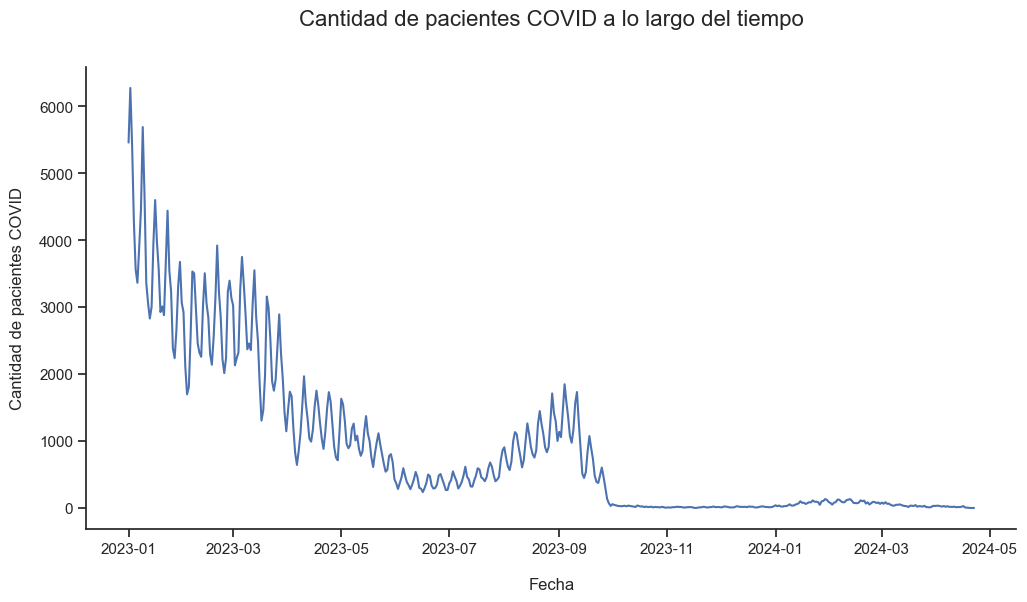

In [7]:
# Crear copia del DataFrame
df_time = df_covid.copy()

# Convert the year, month, and day columns into a single datetime column
df_time['FECHA_SINTOMAS'] = pd.to_datetime(df_time[['AÑO_SINTOMAS', 'MES_SINTOMAS', 'DIA_SINTOMAS']].astype(str).agg('-'.join, axis=1))

# Group by the date and count the occurrences
df_covid_counts = df_time.groupby('FECHA_SINTOMAS').size().reset_index(name='count')

# Set seaborn style
sns.set(style="white")

# Plot the data using seaborn
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_covid_counts, x='FECHA_SINTOMAS', y='count', marker='')

plt.title('Cantidad de pacientes COVID a lo largo del tiempo', fontsize=16, pad=30)
plt.xlabel('Fecha', labelpad=15)
plt.ylabel('Cantidad de pacientes COVID', labelpad=10)

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=True)

# Mantener solo el borde izquierdo y inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

**¿Los picos de contagio coinciden con los picos de fallecimiento?**

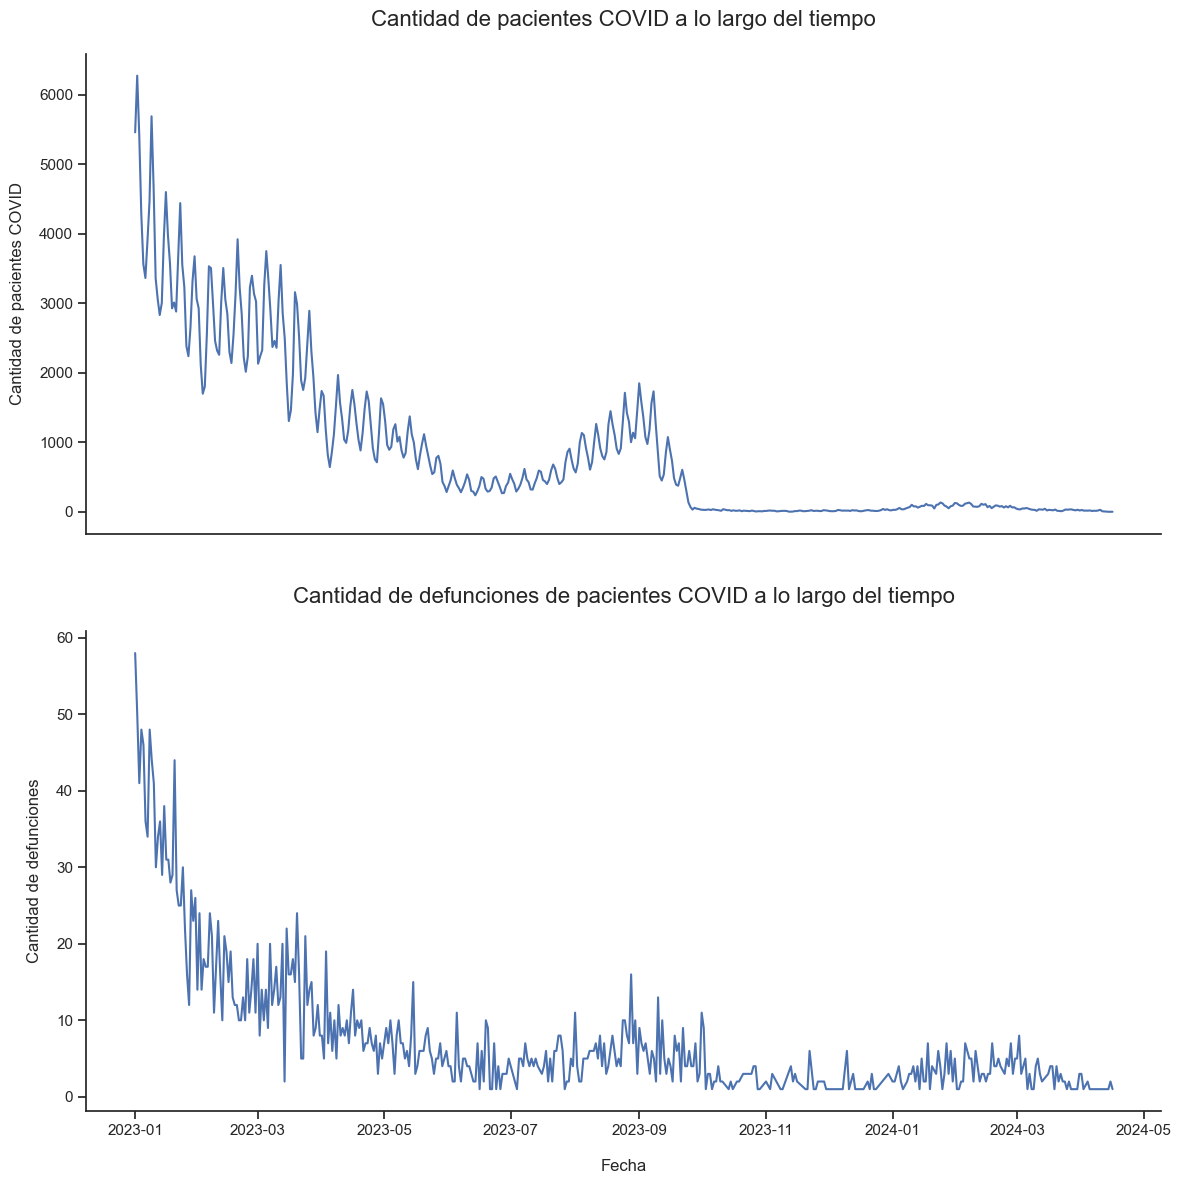

In [8]:
# Filtrar los datos para obtener solo los pacientes fallecidos
df_fallecidos = df_time[df_time['DEFUNCION'] == 1]

# Agrupar por la fecha y contar las ocurrencias de pacientes fallecidos
df_fallecidos_counts = df_fallecidos.groupby('FECHA_SINTOMAS').size().reset_index(name='count')

# Configurar el estilo de seaborn
sns.set(style="white")

# Crear la figura con dos subgráficas, una arriba de otra
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Graficar la cantidad de pacientes diagnosticados con COVID en la subgráfica superior
sns.lineplot(data=df_covid_counts, x='FECHA_SINTOMAS', y='count', marker='', ax=ax1)
ax1.set_title('Cantidad de pacientes COVID a lo largo del tiempo', fontsize=16, pad=20)
ax1.set_xlabel(' ', labelpad=15)
ax1.set_ylabel('Cantidad de pacientes COVID', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica superior
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y de la subgráfica superior
ax1.tick_params(axis='y', which='both', left=True)

# Mantener solo el borde izquierdo y inferior de la subgráfica superior
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Graficar la cantidad de pacientes con COVID que fallecieron en la subgráfica inferior
sns.lineplot(data=df_fallecidos_counts, x='FECHA_SINTOMAS', y='count', marker='', ax=ax2)
ax2.set_title('Cantidad de defunciones de pacientes COVID a lo largo del tiempo', fontsize=16, pad=20)
ax2.set_xlabel('Fecha', labelpad=15)
ax2.set_ylabel('Cantidad de defunciones', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica inferior
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax2.tick_params(axis='y', which='both', left=True)

# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Este análisis arroja una idea de qué combinación de valores de año, mes y día incrementan la probabilidad de fallecimiento por COVID. 

### Geografía 

**¿Qué entidades presentan la mayor cantidad de casos COVID positivos?**

Para hacernos una idea más clara de la magnitud de defunciones por localidad es necesario considerar la cantidad de habitantes de la misma. A partir de ello, tomaremos datos poblacionales del último censo del INEGI y crearemos una nueva columna con la cantidad de defunciones por cada 10 mil habitantes.

Cargamos el catálogo de municipios

In [9]:
# Cargar el catálogo de municipios desde la hoja correcta
file_path = '../../references/processed/Catalogos.xlsx'
catalogo_municipios = pd.read_excel(file_path, sheet_name='Catálogo MUNICIPIOS')

# Mostrar las primeras filas del catálogo para entender su estructura
catalogo_municipios.head()

,CLAVE_MUNICIPIO,MUNICIPIO,CLAVE_ENTIDAD
0,1,AGUASCALIENTES,1
1,2,ASIENTOS,1
2,3,CALVILLO,1
3,4,COSÍO,1
4,5,JESÚS MARÍA,1


Cargamos los datos poblacionales

In [10]:
# Cargar el catálogo de municipios desde la hoja correcta
file_path = '../../data/processed/Datos_poblacion_processed.parquet'
datos_poblacion = pd.read_parquet(file_path)

# Mostrar las primeras filas del catálogo para entender su estructura
datos_poblacion.head()

,CLAVE_ENTIDAD,ENTIDAD,CLAVE_MUNICIPIO,MUNICIPIO,POBLACION
0,1,Aguascalientes,1,Aguascalientes,948990
1,1,Aguascalientes,2,Asientos,51536
2,1,Aguascalientes,3,Calvillo,58250
3,1,Aguascalientes,4,CosÃ­o,17000
4,1,Aguascalientes,5,JesÃºs MarÃ­a,129929


Unimos los Dataframes

In [11]:
# Unir los dataframes en la columna 'CLAVE_MUNICIPIO' y 'CLAVE_ENTIDAD'
poblacion_municipios = pd.merge(catalogo_municipios, datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']],
                                on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')

# Inspeccionamos el nuevo Dataframe
poblacion_municipios.head()

,CLAVE_MUNICIPIO,MUNICIPIO,CLAVE_ENTIDAD,POBLACION
0,1,AGUASCALIENTES,1,948990.0
1,2,ASIENTOS,1,51536.0
2,3,CALVILLO,1,58250.0
3,4,COSÍO,1,17000.0
4,5,JESÚS MARÍA,1,129929.0


In [12]:
# Agregar nombres de entidades al DataFrame de población
poblacion_municipios['ENTIDAD_RES'] = poblacion_municipios['CLAVE_ENTIDAD'].map(ENTIDADES)

# Calcular la población por entidad
poblacion_por_entidad = poblacion_municipios.groupby('ENTIDAD_RES')['POBLACION'].sum().reset_index()

# Inspeccionar el nuevo Dataframe
poblacion_por_entidad.head()

,ENTIDAD_RES,POBLACION
0,Aguascalientes,1425607.0
1,Baja California,3651452.0
2,Baja California Sur,798447.0
3,Campeche,913066.0
4,Chiapas,5532178.0


In [13]:
# Cargar el shapefile de estados/provincias de Natural Earth
gdf = gpd.read_file('ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

# Filtrar solo las entidades de México
gdf = gdf[gdf['admin'] == 'Mexico']

# Diccionario para remapear el nombre de algunos estados para que coincidan con nuestros datos
remap_entidades = {
    "Distrito Federal": "Ciudad de México",
    "Coahuila": "Coahuila de Zaragoza",
    "México": "Edo. de México",
    "Michoacán": "Michoacán de Ocampo",
    "Veracruz": "Veracruz de Ignacio de la Llave"
}

# Remapeo de nombres de estados
gdf["name"] = gdf["name"].map(remap_entidades).fillna(gdf["name"])


In [14]:
# Crear copía del dataframe
df_map = df_covid.copy()

# Convertir los valores de la columna 'ENTIDAD_RES' usando el diccionario
df_map['ENTIDAD_RES'] = df_map['ENTIDAD_RES'].map(ENTIDADES)

# Calcular el número de casos diagnosticados con COVID-19 por entidad federativa
casos_por_entidad = df_map['ENTIDAD_RES'].value_counts().reset_index()
casos_por_entidad.columns = ['ENTIDAD_RES', 'Casos']

# Combinar casos con población
casos_por_entidad = pd.merge(casos_por_entidad, poblacion_por_entidad, on='ENTIDAD_RES', how='left')

# Calcular los casos por cada 10 mil habitantes
casos_por_entidad['Casos_per_10k'] = (casos_por_entidad['Casos'] / casos_por_entidad['POBLACION']) * 10000

# Inspeccionar el nuevo Dataframe
casos_por_entidad.head()

,ENTIDAD_RES,Casos,POBLACION,Casos_per_10k
0,Ciudad de México,112835,9209944.0,122.514317
1,Edo. de México,48522,16992418.0,28.555089
2,Nuevo León,31910,5784442.0,55.165217
3,Guanajuato,19186,6166934.0,31.111084
4,Baja California,15782,3651452.0,43.221162


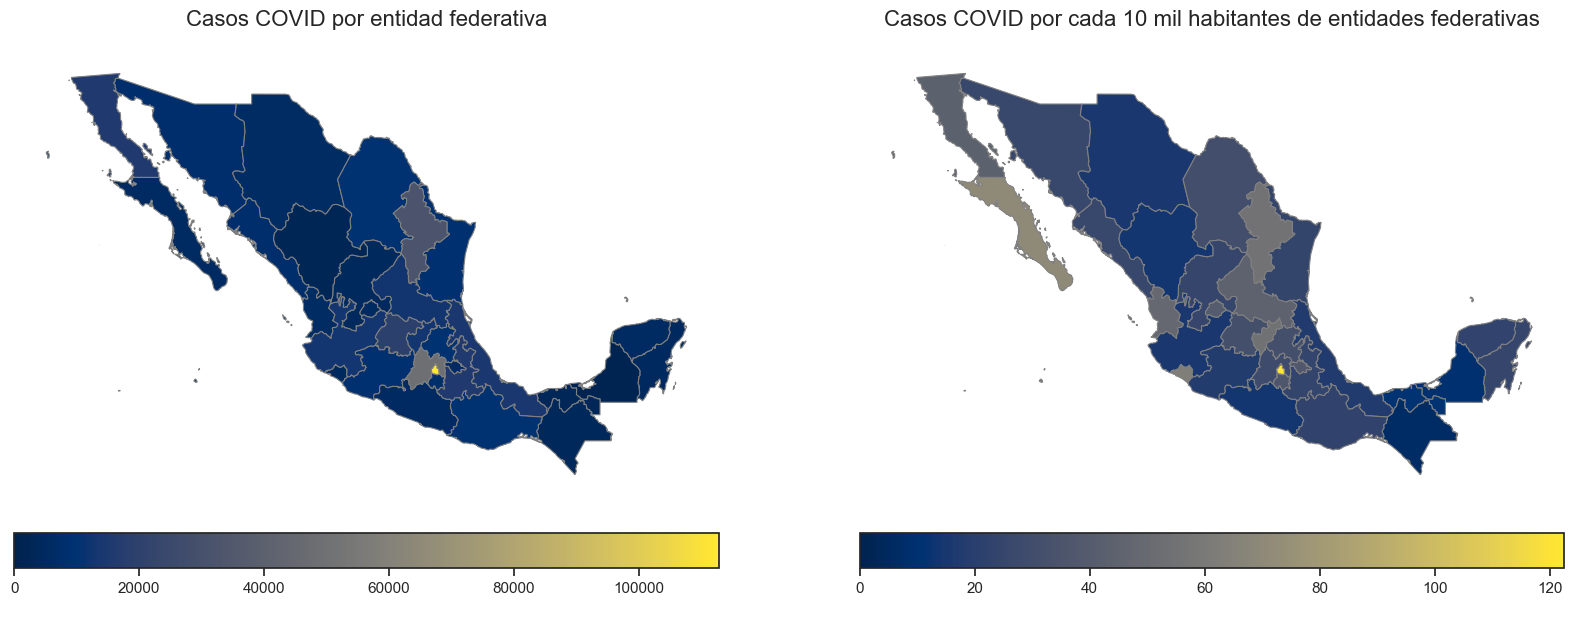

In [15]:
# Combinar los datos de casos con el GeoDataFrame de México
gdf_casos = gdf.merge(casos_por_entidad, left_on='name', right_on='ENTIDAD_RES', how='left').fillna(0)

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Mapa de casos diagnosticados
gdf_casos.plot(column='Casos', cmap='cividis', linewidth=0.8, ax=ax1, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax1.set_title('Casos COVID por entidad federativa', fontsize=16, pad=20)
ax1.axis('off')

# Mapa de casos por cada 10 mil habitantes
gdf_casos.plot(column='Casos_per_10k', cmap='cividis', linewidth=0.8, ax=ax2, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax2.set_title('Casos COVID por cada 10 mil habitantes de entidades federativas', fontsize=16, pad=20)
ax2.axis('off')

# Mostrar la figura
plt.show()

**¿Los estados que tienen más casos de COVID son también los que tienen más defunciones?**

In [16]:
# Calcular el número de defunciones por entidad federativa
defunciones_por_entidad = df_map[df_map['DEFUNCION'] == 1]['ENTIDAD_RES'].value_counts().reset_index()
defunciones_por_entidad.columns = ['ENTIDAD_RES', 'Defunciones']

# Combinar defunciones con población
defunciones_por_entidad = pd.merge(defunciones_por_entidad, poblacion_por_entidad, on='ENTIDAD_RES', how='left')

# Calcular los casos por cada 10 mil habitantes
defunciones_por_entidad['Defunciones_per_10k'] = (defunciones_por_entidad['Defunciones'] / defunciones_por_entidad['POBLACION']) * 10000

# Inspeccionar el nuevo Dataframe
defunciones_por_entidad.head()

,ENTIDAD_RES,Defunciones,POBLACION,Defunciones_per_10k
0,Ciudad de México,471,9209944.0,0.511404
1,Edo. de México,374,16992418.0,0.220098
2,Jalisco,210,8348151.0,0.251553
3,Nuevo León,186,5784442.0,0.321552
4,Veracruz de Ignacio de la Llave,184,8062579.0,0.228215


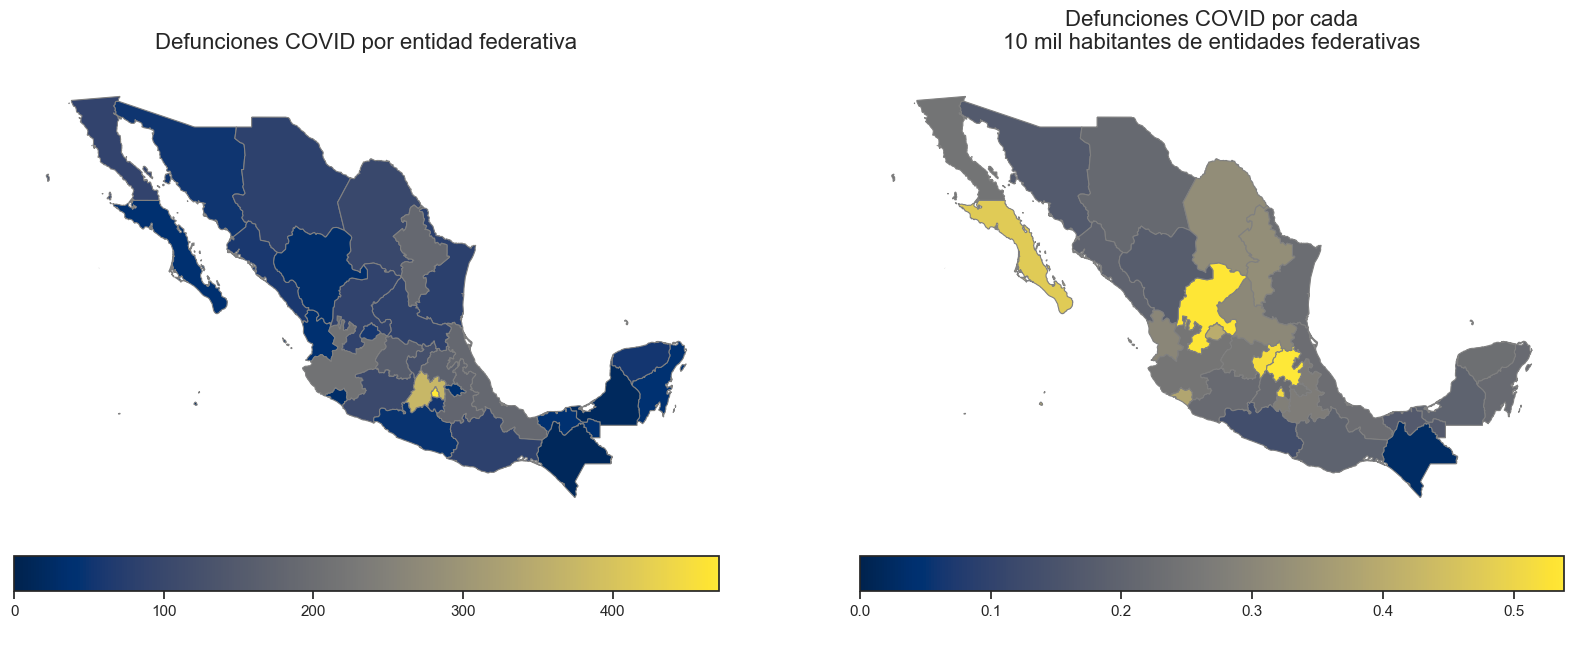

In [17]:
# Combinar los datos de defunciones con el GeoDataFrame de México
gdf_defunciones = gdf.merge(defunciones_por_entidad, left_on='name', right_on='ENTIDAD_RES', how='left').fillna(0)

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Mapa de casos diagnosticados
gdf_defunciones.plot(column='Defunciones', cmap='cividis', linewidth=0.8, ax=ax1, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax1.set_title('Defunciones COVID por entidad federativa', fontsize=16, pad=20)
ax1.axis('off')

# Mapa de defunciones
gdf_defunciones.plot(column='Defunciones_per_10k', cmap='cividis', linewidth=0.8, ax=ax2, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax2.set_title('Defunciones COVID por cada\n10 mil habitantes de entidades federativas', fontsize=16, pad=20)
ax2.axis('off')

# Mostrar la figura
plt.show()

Notamos que los estados de Jalisco e Hidalgo, a pesar de no haber presentado tantos casos confirmados de COVID como otros estados, son de las entidades con mayor número de fallecidos. 

**En las entidades con más defunciones, ¿cuáles fueron los municipios más afectados?**

Identificamos a las 3 entidades con más defunciones

In [18]:
# Extraer entidades con más defunciones
entidades_top_3_defunciones = defunciones_por_entidad['ENTIDAD_RES'][:3].to_list()

# Imprimimos el resultado
entidades_top_3_defunciones

['Ciudad de México', 'Edo. de México', 'Jalisco']

Identificamos a las 3 entidades con más defunciones por cada 10 mil habitantes

In [19]:
entidades_top_3_defunciones_per_10k = defunciones_por_entidad.sort_values(by='Defunciones_per_10k', ascending=False)['ENTIDAD_RES'][:3].to_list()

# Imprimimos el resultado
entidades_top_3_defunciones_per_10k

['Hidalgo', 'Zacatecas', 'Querétaro']

Extraer datos de las entidades específicas

In [20]:
# Crear copia de dataframe
df_municipio = df_defuncion.copy()

# Filtrar los datos de las entidades específicas
df_fallecidos_cdmx = df_municipio[df_municipio['ENTIDAD_RES'] == 9]
df_fallecidos_edomx = df_municipio[df_municipio['ENTIDAD_RES'] == 15]
df_fallecidos_jal = df_municipio[df_municipio['ENTIDAD_RES'] == 14]
df_fallecidos_hgo = df_municipio[df_municipio['ENTIDAD_RES'] == 13]
df_fallecidos_zac = df_municipio[df_municipio['ENTIDAD_RES'] == 32]
df_fallecidos_qro = df_municipio[df_municipio['ENTIDAD_RES'] == 22]

Calcular el número de fallecidos por municipio en cada entidad

In [21]:
# Calcular el número de fallecidos por municipio en cada entidad
fallecidos_cdmx_municipio = df_fallecidos_cdmx['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_cdmx_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_edomx_municipio = df_fallecidos_edomx['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_edomx_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_jal_municipio = df_fallecidos_jal['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_jal_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_hgo_municipio = df_fallecidos_hgo['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_hgo_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_zac_municipio = df_fallecidos_zac['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_zac_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_qro_municipio = df_fallecidos_qro['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_qro_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

Añadir nombres de municipios por medio de los catálogos

In [22]:
# Filtrar los catálogos de municipios para cada entidad
catalogo_cdmx = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 9]
catalogo_edomx = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 15]
catalogo_jal = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 14]
catalogo_hgo = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 13]
catalogo_zac = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 32]
catalogo_qro = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 22]

# Combinar los datos de defunciones con los catálogos de municipios
fallecidos_cdmx = fallecidos_cdmx_municipio.merge(catalogo_cdmx, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_edomx = fallecidos_edomx_municipio.merge(catalogo_edomx, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_jal = fallecidos_jal_municipio.merge(catalogo_jal, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_hgo = fallecidos_hgo_municipio.merge(catalogo_hgo, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_zac = fallecidos_zac_municipio.merge(catalogo_zac, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_qro = fallecidos_qro_municipio.merge(catalogo_qro, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')

Añadir datos de población y calcular defunciones por cada 10 mil habitantes

In [23]:
# Añadir la población a cada DataFrame
fallecidos_cdmx = fallecidos_cdmx.merge(datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']], on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')
fallecidos_edomx = fallecidos_edomx.merge(datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']], on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')
fallecidos_jal = fallecidos_jal.merge(datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']], on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')
fallecidos_hgo = fallecidos_hgo.merge(datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']], on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')
fallecidos_zac = fallecidos_zac.merge(datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']], on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')
fallecidos_qro = fallecidos_qro.merge(datos_poblacion[['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO', 'POBLACION']], on=['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'], how='left')

# Calcular las defunciones por cada 10 mil habitantes
fallecidos_cdmx['Defunciones_per_10k'] = (fallecidos_cdmx['Defunciones'] / fallecidos_cdmx['POBLACION']) * 10000
fallecidos_edomx['Defunciones_per_10k'] = (fallecidos_edomx['Defunciones'] / fallecidos_edomx['POBLACION']) * 10000
fallecidos_jal['Defunciones_per_10k'] = (fallecidos_jal['Defunciones'] / fallecidos_jal['POBLACION']) * 10000
fallecidos_hgo['Defunciones_per_10k'] = (fallecidos_hgo['Defunciones'] / fallecidos_hgo['POBLACION']) * 10000
fallecidos_zac['Defunciones_per_10k'] = (fallecidos_zac['Defunciones'] / fallecidos_zac['POBLACION']) * 10000
fallecidos_qro['Defunciones_per_10k'] = (fallecidos_qro['Defunciones'] / fallecidos_qro['POBLACION']) * 10000

Ordenar los datos de mayor a menor

In [24]:
# Ordenar los datos de mayor a menor
fallecidos_cdmx = fallecidos_cdmx.sort_values(by='Defunciones', ascending=False)
fallecidos_edomx = fallecidos_edomx.sort_values(by='Defunciones', ascending=False)
fallecidos_jal = fallecidos_jal.sort_values(by='Defunciones', ascending=False)
fallecidos_hgo = fallecidos_hgo.sort_values(by='Defunciones', ascending=False)
fallecidos_zac = fallecidos_zac.sort_values(by='Defunciones', ascending=False)
fallecidos_qro = fallecidos_qro.sort_values(by='Defunciones', ascending=False)

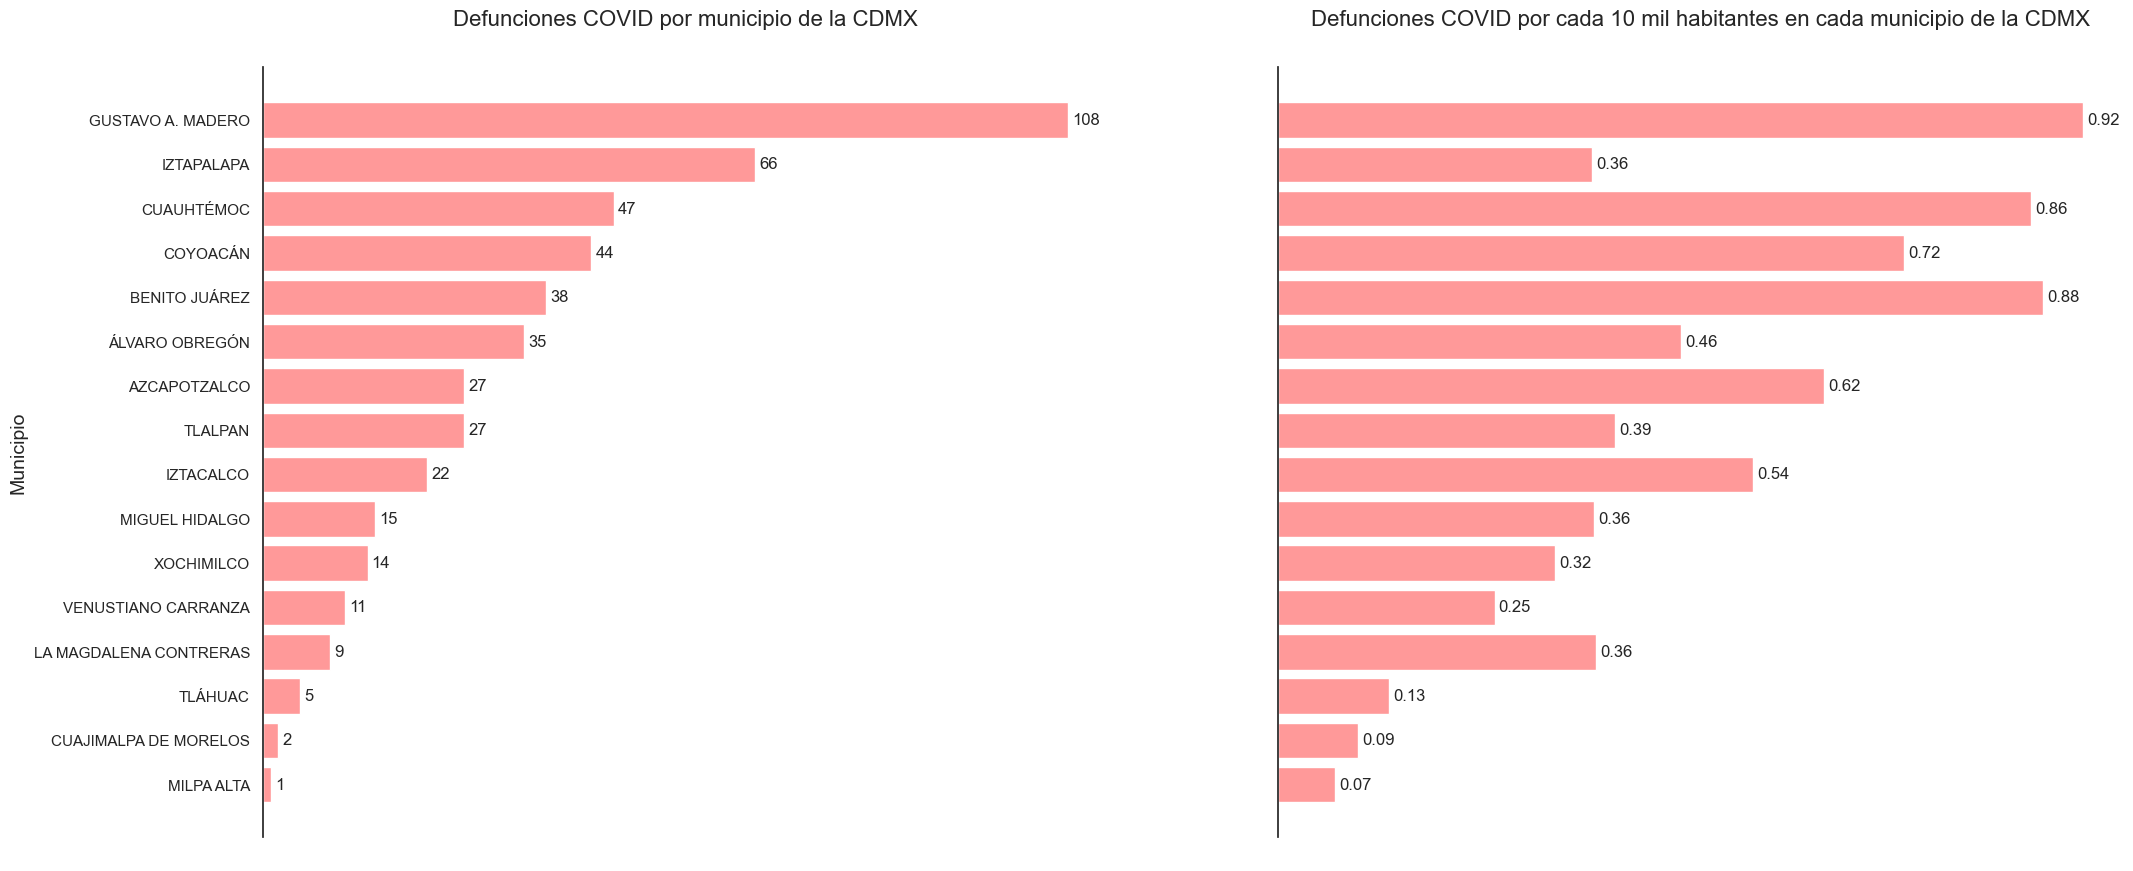

In [25]:
# Crear gráficos de barras horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Gráfico para el número de defunciones
bars1 = ax1.barh(fallecidos_cdmx['MUNICIPIO'], fallecidos_cdmx['Defunciones'], color='#ff9999')
ax1.set_title('Defunciones COVID por municipio de la CDMX', fontsize=16, pad=30)
ax1.set_xlabel(' ', fontsize=14)
ax1.set_ylabel('Municipio', fontsize=14)
ax1.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Gráfico para el número de defunciones por cada 10 mil habitantes
bars2 = ax2.barh(fallecidos_cdmx['MUNICIPIO'], fallecidos_cdmx['Defunciones_per_10k'], color='#ff9999')
ax2.set_title('Defunciones COVID por cada 10 mil habitantes en cada municipio de la CDMX', fontsize=16, pad=30)
ax2.set_xlabel(' ', fontsize=14)
ax2.set_ylabel('', fontsize=14)
ax2.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Añadir el número de defunciones por cada 10 mil habitantes encima de cada barra
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.2f}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Mostrar la figura
plt.show()

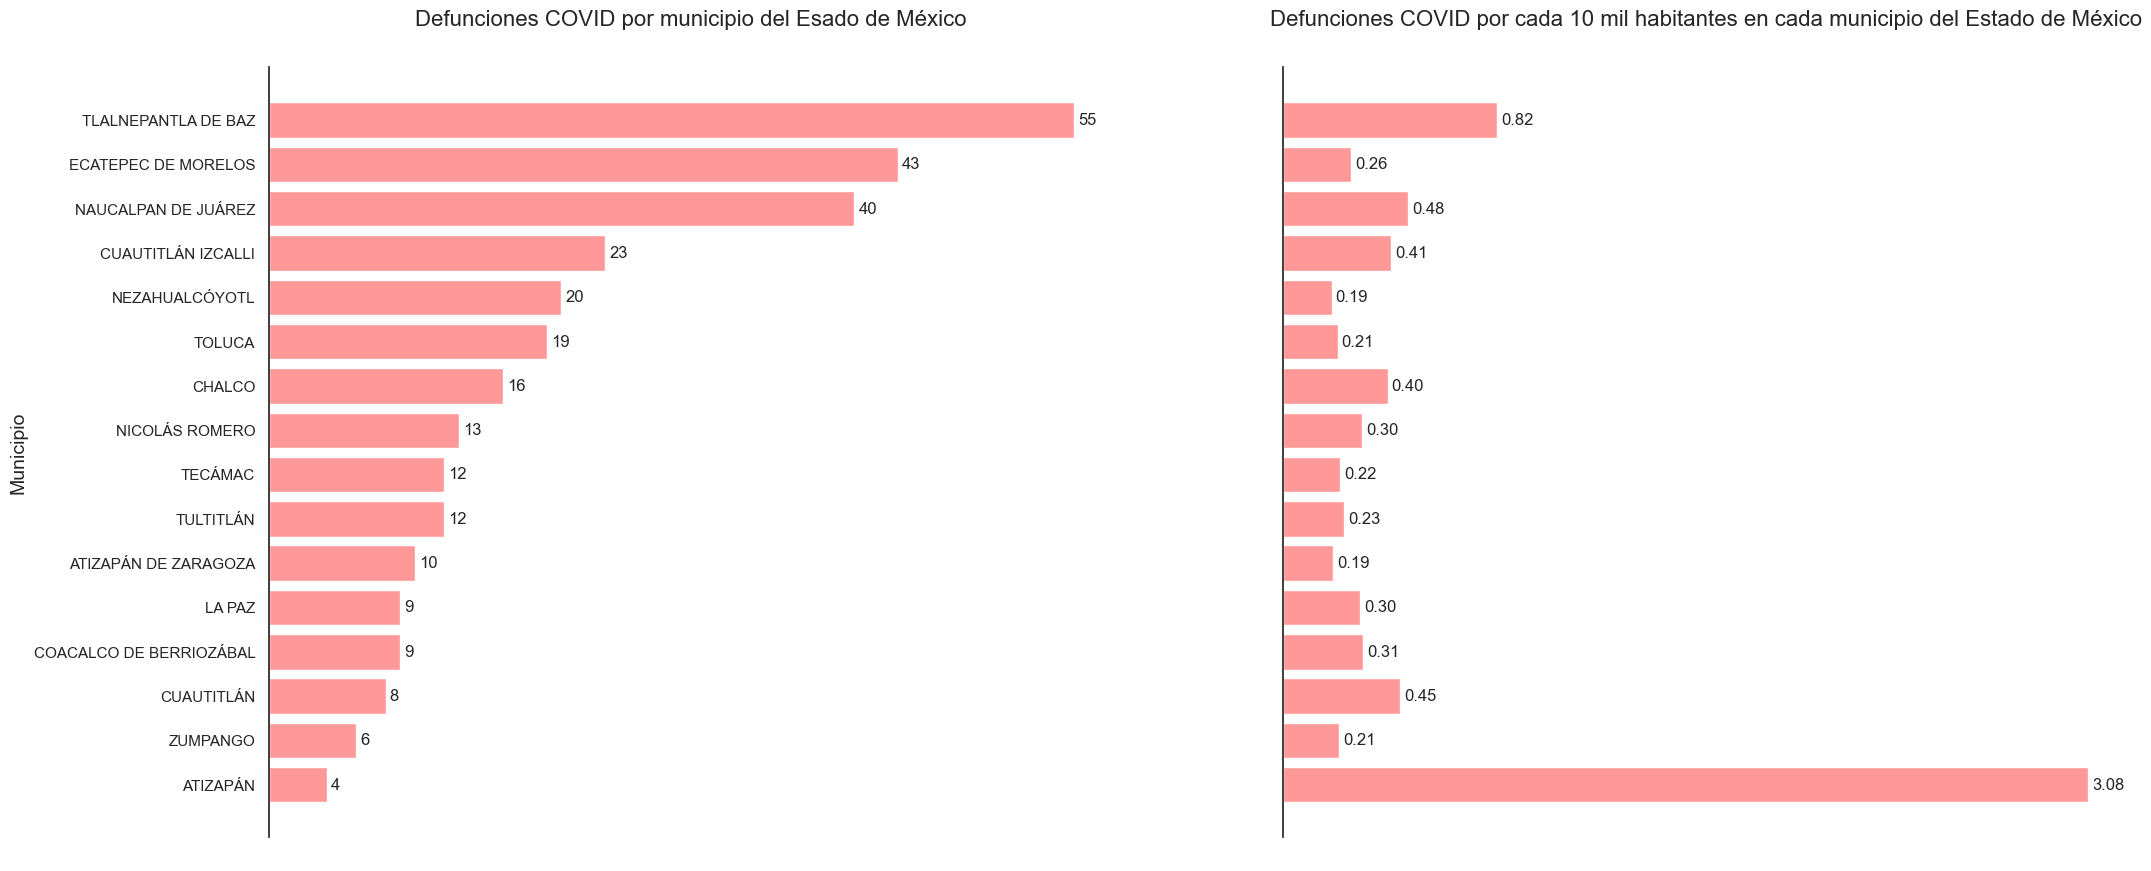

In [26]:
# Crear gráficos de barras horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Gráfico para el número de defunciones
bars1 = ax1.barh(fallecidos_edomx['MUNICIPIO'][:16], fallecidos_edomx['Defunciones'][:16], color='#ff9999')
ax1.set_title('Defunciones COVID por municipio del Esado de México', fontsize=16, pad=30)
ax1.set_xlabel(' ', fontsize=14)
ax1.set_ylabel('Municipio', fontsize=14)
ax1.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Gráfico para el número de defunciones por cada 10 mil habitantes
bars2 = ax2.barh(fallecidos_edomx['MUNICIPIO'][:16], fallecidos_edomx['Defunciones_per_10k'][:16], color='#ff9999')
ax2.set_title('Defunciones COVID por cada 10 mil habitantes en cada municipio del Estado de México', fontsize=16, pad=30)
ax2.set_xlabel(' ', fontsize=14)
ax2.set_ylabel('', fontsize=14)
ax2.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Añadir el número de defunciones por cada 10 mil habitantes encima de cada barra
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.2f}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Mostrar la figura
plt.show()

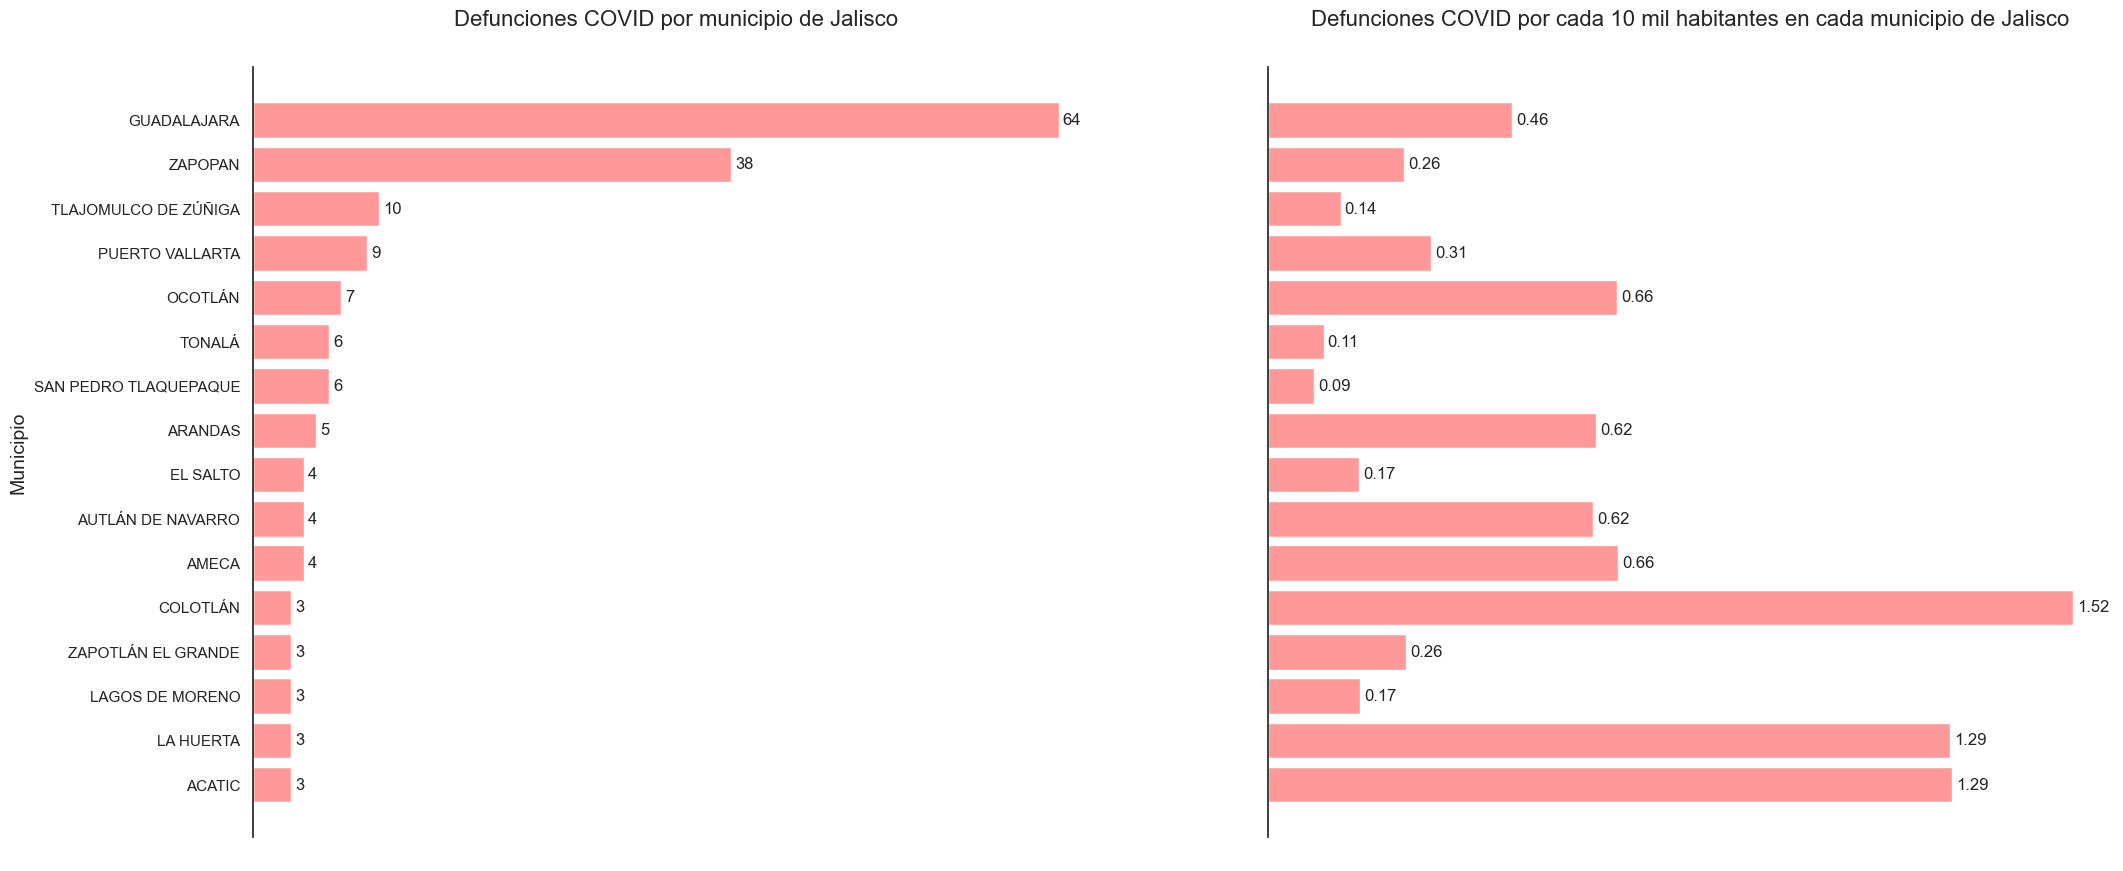

In [27]:
# Crear gráficos de barras horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Gráfico para el número de defunciones
bars1 = ax1.barh(fallecidos_jal['MUNICIPIO'][:16], fallecidos_jal['Defunciones'][:16], color='#ff9999')
ax1.set_title('Defunciones COVID por municipio de Jalisco', fontsize=16, pad=30)
ax1.set_xlabel(' ', fontsize=14)
ax1.set_ylabel('Municipio', fontsize=14)
ax1.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Gráfico para el número de defunciones por cada 10 mil habitantes
bars2 = ax2.barh(fallecidos_jal['MUNICIPIO'][:16], fallecidos_jal['Defunciones_per_10k'][:16], color='#ff9999')
ax2.set_title('Defunciones COVID por cada 10 mil habitantes en cada municipio de Jalisco', fontsize=16, pad=30)
ax2.set_xlabel(' ', fontsize=14)
ax2.set_ylabel('', fontsize=14)
ax2.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Añadir el número de defunciones por cada 10 mil habitantes encima de cada barra
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.2f}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Mostrar la figura
plt.show()

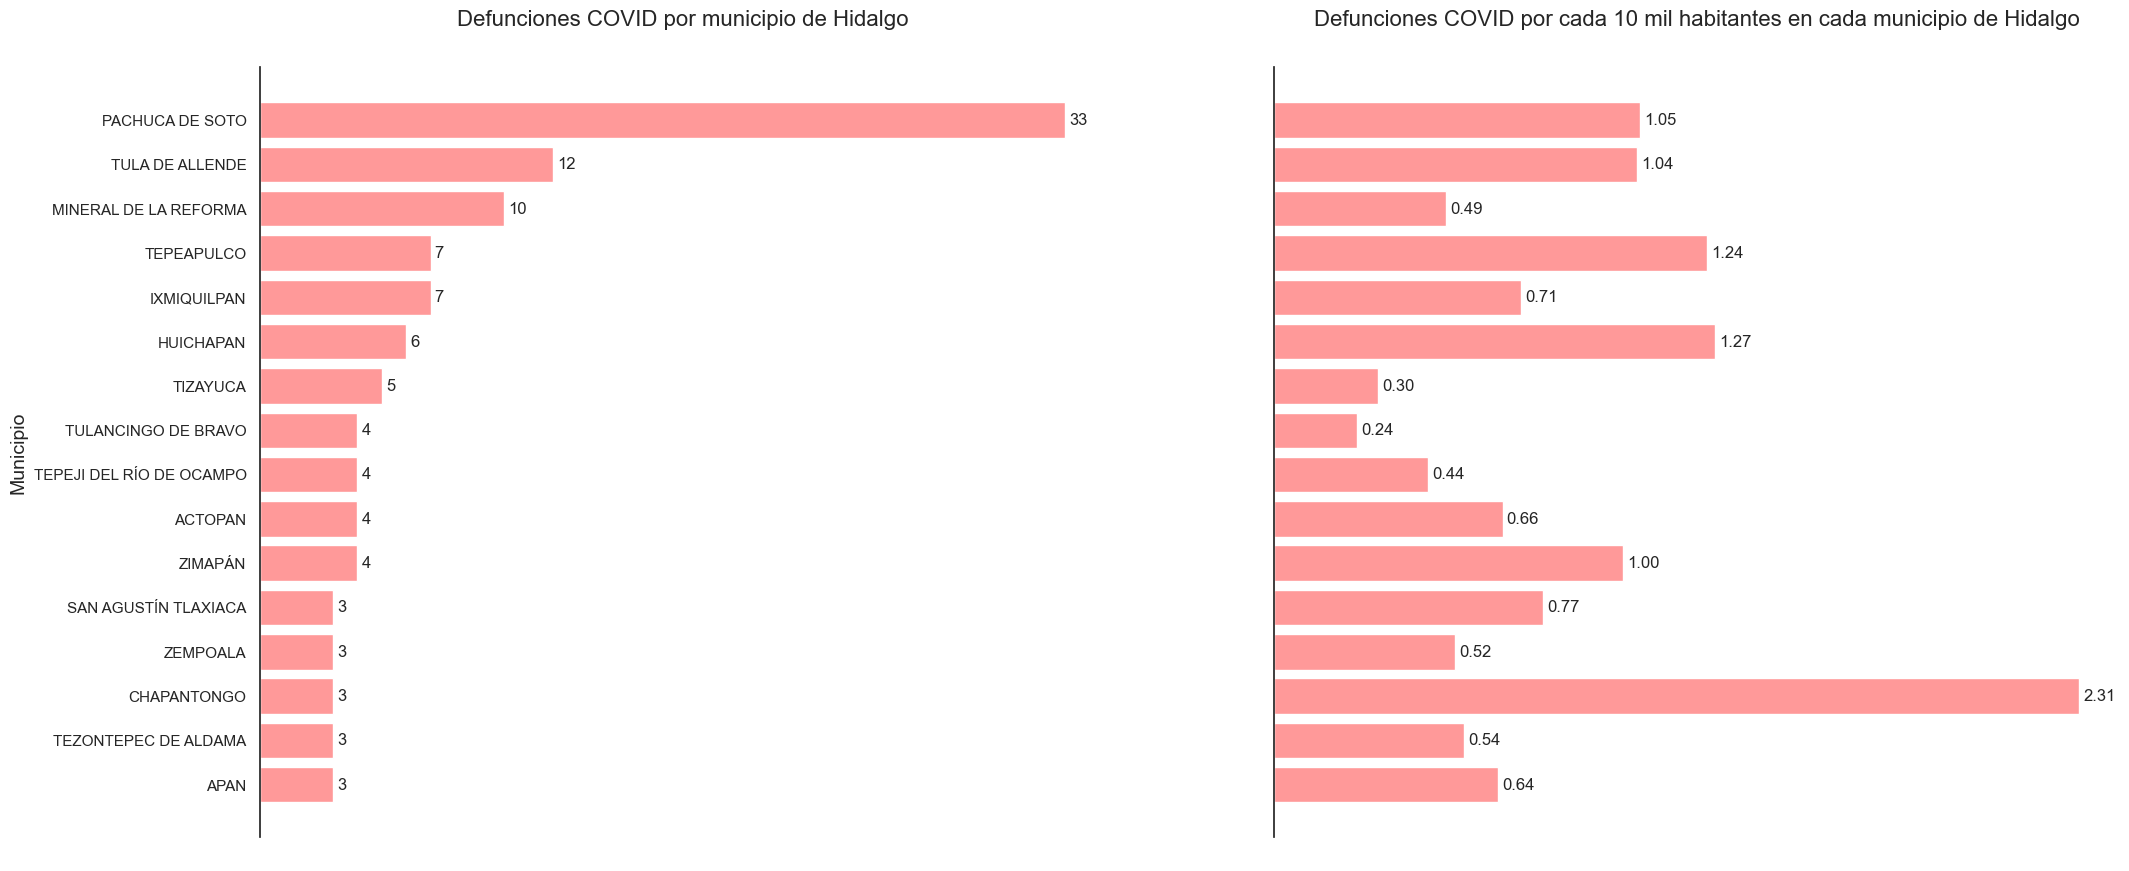

In [28]:
# Crear gráficos de barras horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Gráfico para el número de defunciones
bars1 = ax1.barh(fallecidos_hgo['MUNICIPIO'][:16], fallecidos_hgo['Defunciones'][:16], color='#ff9999')
ax1.set_title('Defunciones COVID por municipio de Hidalgo', fontsize=16, pad=30)
ax1.set_xlabel(' ', fontsize=14)
ax1.set_ylabel('Municipio', fontsize=14)
ax1.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Gráfico para el número de defunciones por cada 10 mil habitantes
bars2 = ax2.barh(fallecidos_hgo['MUNICIPIO'][:16], fallecidos_hgo['Defunciones_per_10k'][:16], color='#ff9999')
ax2.set_title('Defunciones COVID por cada 10 mil habitantes en cada municipio de Hidalgo', fontsize=16, pad=30)
ax2.set_xlabel(' ', fontsize=14)
ax2.set_ylabel('', fontsize=14)
ax2.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Añadir el número de defunciones por cada 10 mil habitantes encima de cada barra
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.2f}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Mostrar la figura
plt.show()

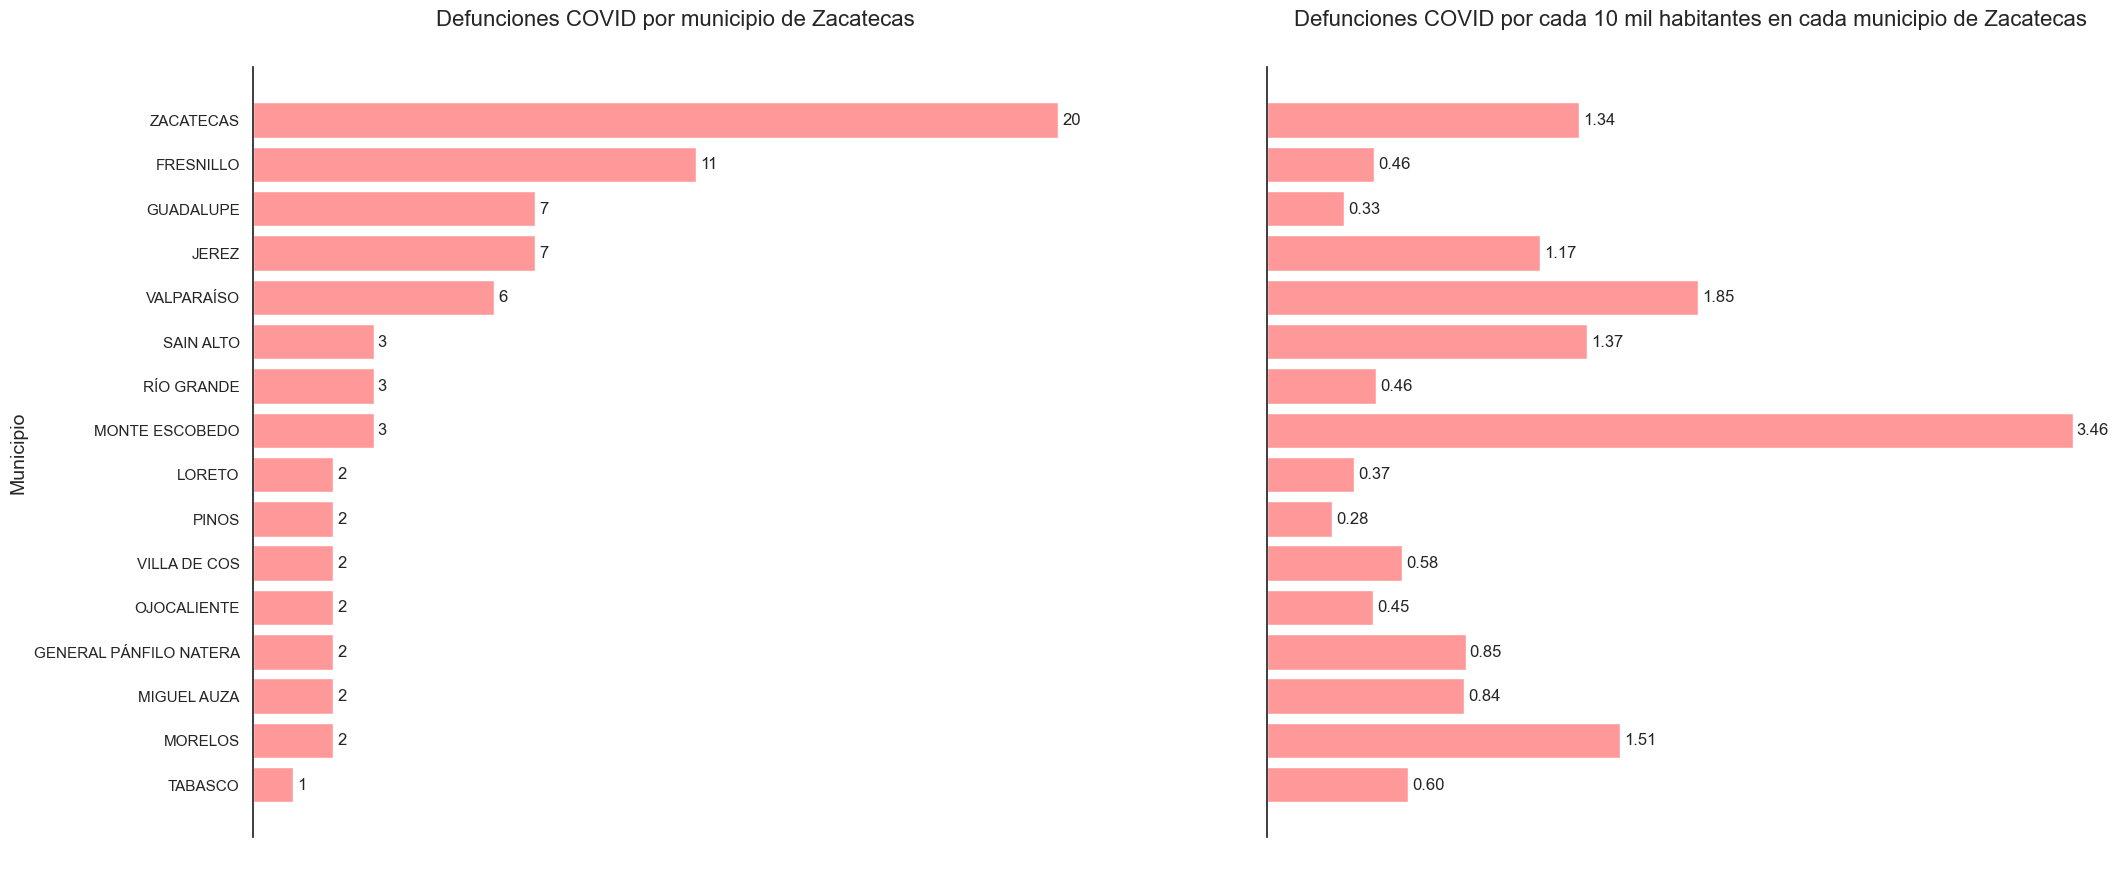

In [29]:
# Crear gráficos de barras horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Gráfico para el número de defunciones
bars1 = ax1.barh(fallecidos_zac['MUNICIPIO'][:16], fallecidos_zac['Defunciones'][:16], color='#ff9999')
ax1.set_title('Defunciones COVID por municipio de Zacatecas', fontsize=16, pad=30)
ax1.set_xlabel(' ', fontsize=14)
ax1.set_ylabel('Municipio', fontsize=14)
ax1.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Gráfico para el número de defunciones por cada 10 mil habitantes
bars2 = ax2.barh(fallecidos_zac['MUNICIPIO'][:16], fallecidos_zac['Defunciones_per_10k'][:16], color='#ff9999')
ax2.set_title('Defunciones COVID por cada 10 mil habitantes en cada municipio de Zacatecas', fontsize=16, pad=30)
ax2.set_xlabel(' ', fontsize=14)
ax2.set_ylabel('', fontsize=14)
ax2.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Añadir el número de defunciones por cada 10 mil habitantes encima de cada barra
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.2f}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Mostrar la figura
plt.show()

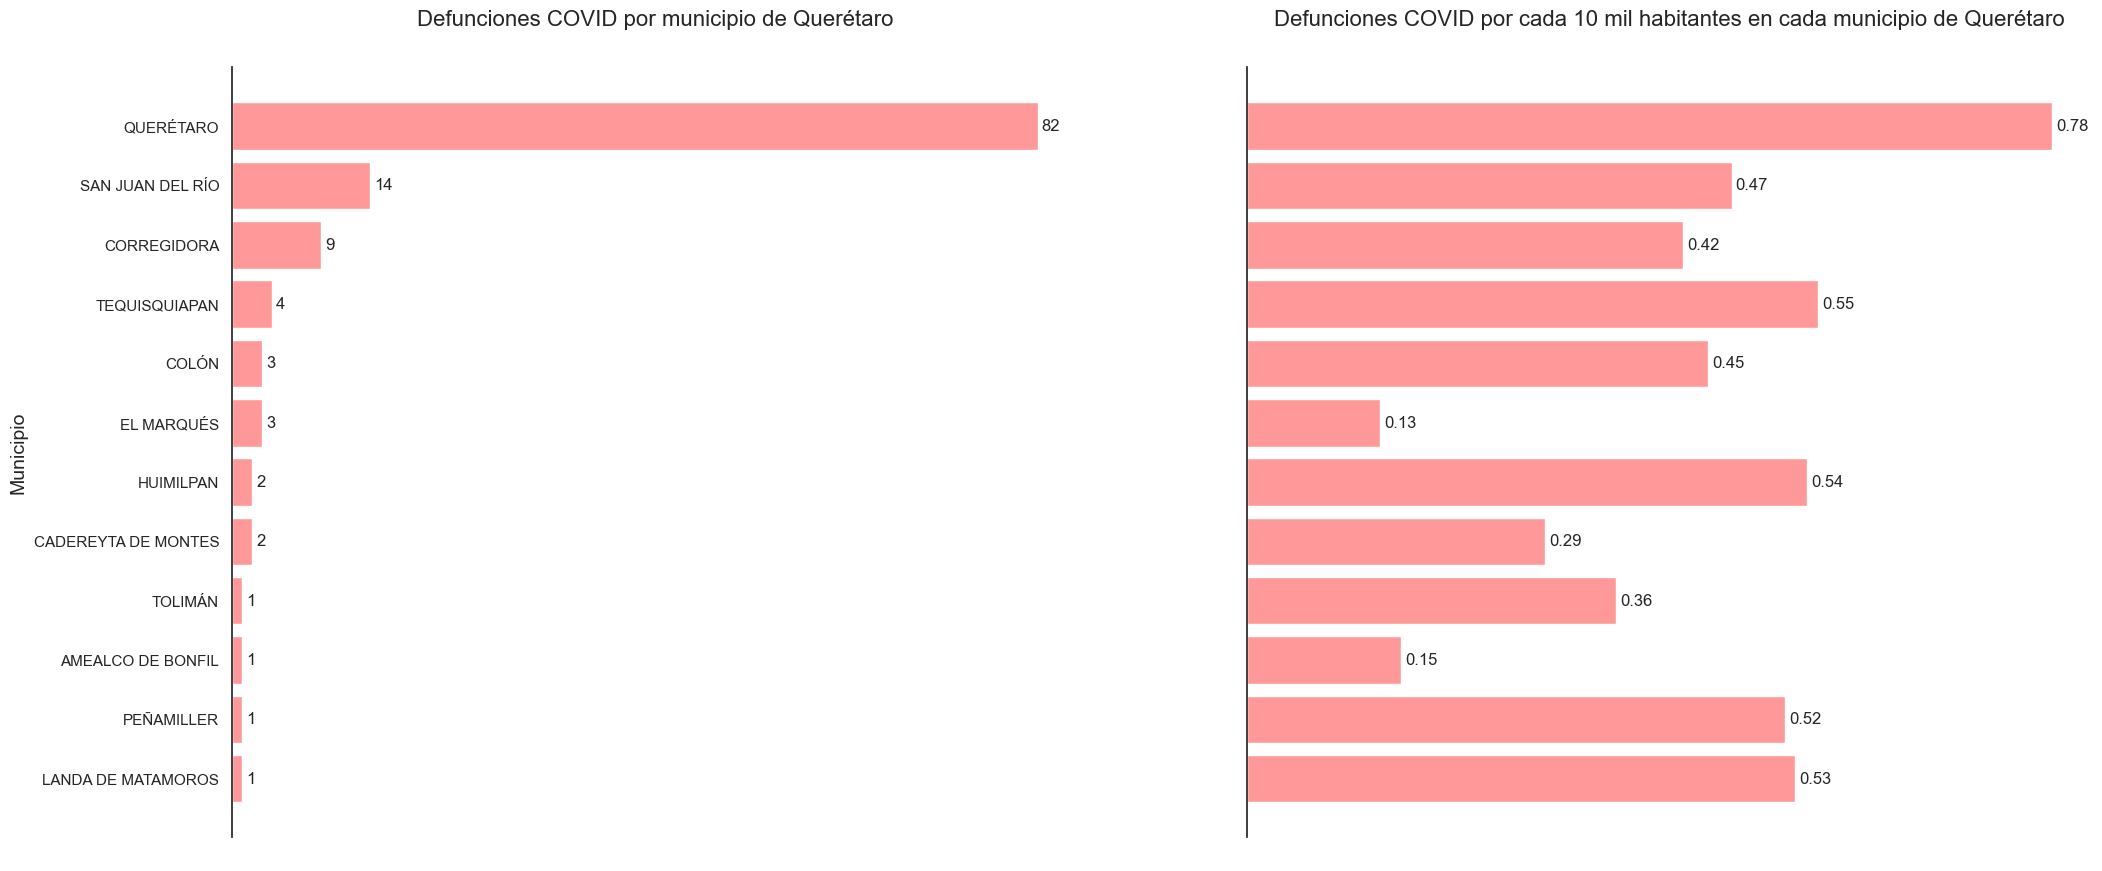

In [30]:
# Crear gráficos de barras horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Gráfico para el número de defunciones
bars1 = ax1.barh(fallecidos_qro['MUNICIPIO'][:16], fallecidos_qro['Defunciones'][:16], color='#ff9999')
ax1.set_title('Defunciones COVID por municipio de Querétaro', fontsize=16, pad=30)
ax1.set_xlabel(' ', fontsize=14)
ax1.set_ylabel('Municipio', fontsize=14)
ax1.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Gráfico para el número de defunciones por cada 10 mil habitantes
bars2 = ax2.barh(fallecidos_qro['MUNICIPIO'][:16], fallecidos_qro['Defunciones_per_10k'][:16], color='#ff9999')
ax2.set_title('Defunciones COVID por cada 10 mil habitantes en cada municipio de Querétaro', fontsize=16, pad=30)
ax2.set_xlabel(' ', fontsize=14)
ax2.set_ylabel('', fontsize=14)
ax2.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Añadir el número de defunciones por cada 10 mil habitantes encima de cada barra
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.2f}',
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center')

# Mostrar la figura
plt.show()

Este análisis nos permite hacernos una idea de la relevancia que tiene no solo la entidad, sino el municipio específico en el que se encuentra la persona al ser diagnósticaga con COVID para determinar sus probabilidades de defunción. 

### Demografía

**¿Cómo influye la edad de los pacientes COVID positivos en el porcentaje de fallecimiento?**

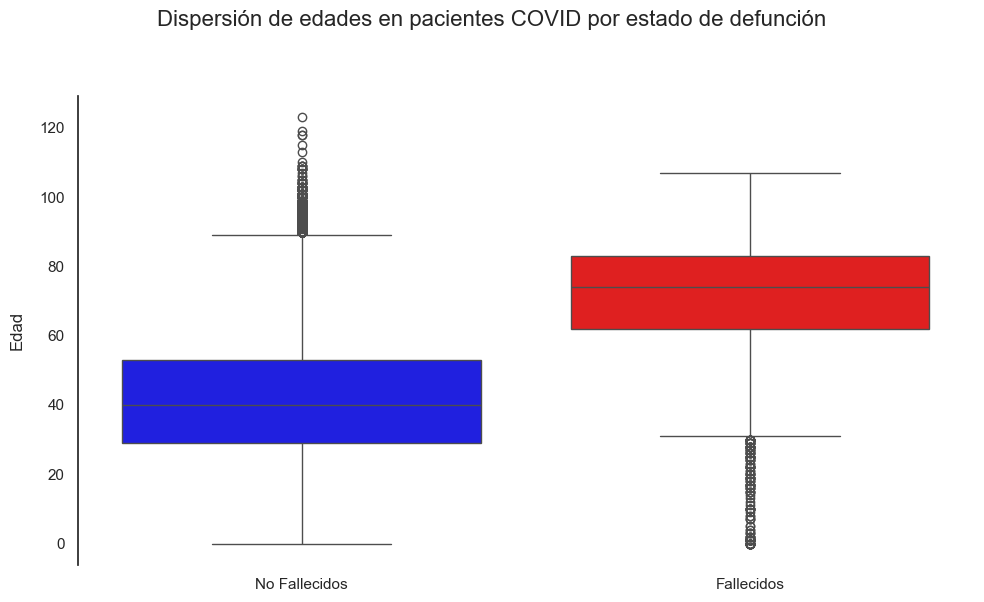

In [31]:
# Separar los datos en fallecidos y no fallecidos
fallecidos = df_covid[df_covid['DEFUNCION'] == 1]
no_fallecidos = df_covid[df_covid['DEFUNCION'] == 2]

# Crear un DataFrame para facilitar la creación de los boxplots
data = pd.DataFrame({
    'Edad': df_covid['EDAD'],
    'Estado': ['Fallecidos' if x == 1 else 'No Fallecidos' for x in df_covid['DEFUNCION']]
})

# Crear boxplots para ambas distribuciones
fig, ax = plt.subplots(figsize=(10, 6))

# Título superior de la figura
fig.suptitle('Dispersión de edades en pacientes COVID por estado de defunción', fontsize=16, y=1.00)

# Crear boxplot
sns.boxplot(x='Estado', y='Edad', data=data, ax=ax, palette={'Fallecidos': 'red', 'No Fallecidos': 'blue'})

# Títulos y etiquetas
ax.set_xlabel('', labelpad=15)
ax.set_ylabel('Edad', labelpad=10)

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y
#ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

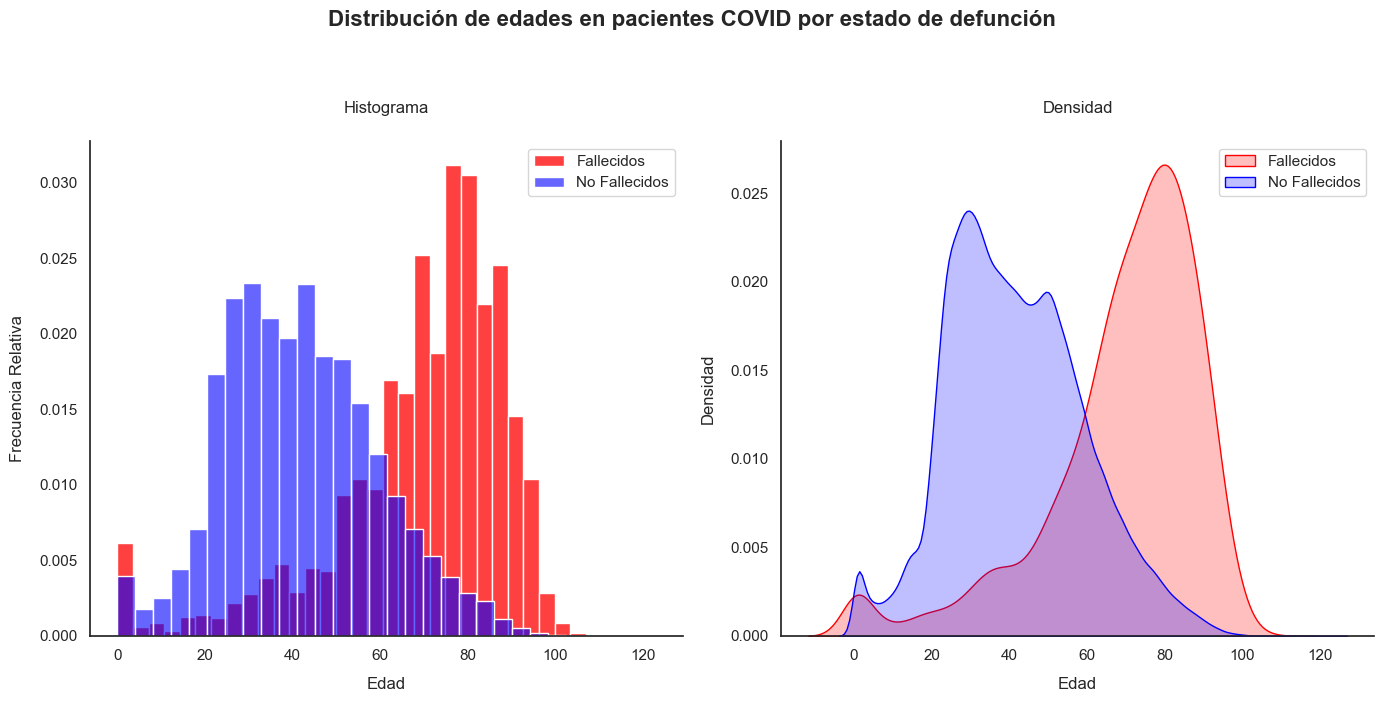

In [32]:

# Separar los datos en fallecidos y no fallecidos
fallecidos = df_covid[df_covid['DEFUNCION'] == 1]
no_fallecidos = df_covid[df_covid['DEFUNCION'] == 2]

# Crear histogramas de frecuencia relativa y gráficos de densidad para ambas distribuciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Título superior de la figura
fig.suptitle('Distribución de edades en pacientes COVID por estado de defunción', fontsize=16, y=1.00, fontweight='bold')

# Histograma de frecuencia relativa sin edges
sns.histplot(fallecidos['EDAD'], color='red', kde=False, label='Fallecidos', bins=30, stat='density', edgecolor=None, ax=ax1)
sns.histplot(no_fallecidos['EDAD'], color='blue', kde=False, label='No Fallecidos', bins=30, stat='density', alpha=0.6, edgecolor=None, ax=ax1)
ax1.set_title('Histograma', pad=20)
ax1.set_xlabel('Edad', labelpad=10)
ax1.set_ylabel('Frecuencia Relativa', labelpad=10)
ax1.legend()

# Desactivar las marcas en el eje x
#ax1.tick_params(axis='x', which='both', bottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Gráfico de Densidad
sns.kdeplot(fallecidos['EDAD'], color='red', label='Fallecidos', shade=True, ax=ax2)
sns.kdeplot(no_fallecidos['EDAD'], color='blue', label='No Fallecidos', shade=True, ax=ax2)
ax2.set_title('Densidad', pad=20)
ax2.set_xlabel('Edad', labelpad=10)
ax2.set_ylabel('Densidad', labelpad=10)
ax2.legend()

# Desactivar las marcas en el eje x
#ax2.tick_params(axis='x', which='both', bottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**¿Cómo influye el sexo de los pacientes COVID positivos en el porcentaje de fallecimiento?**

In [33]:
# Función para calcular el tamaño del efecto con el valor de Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

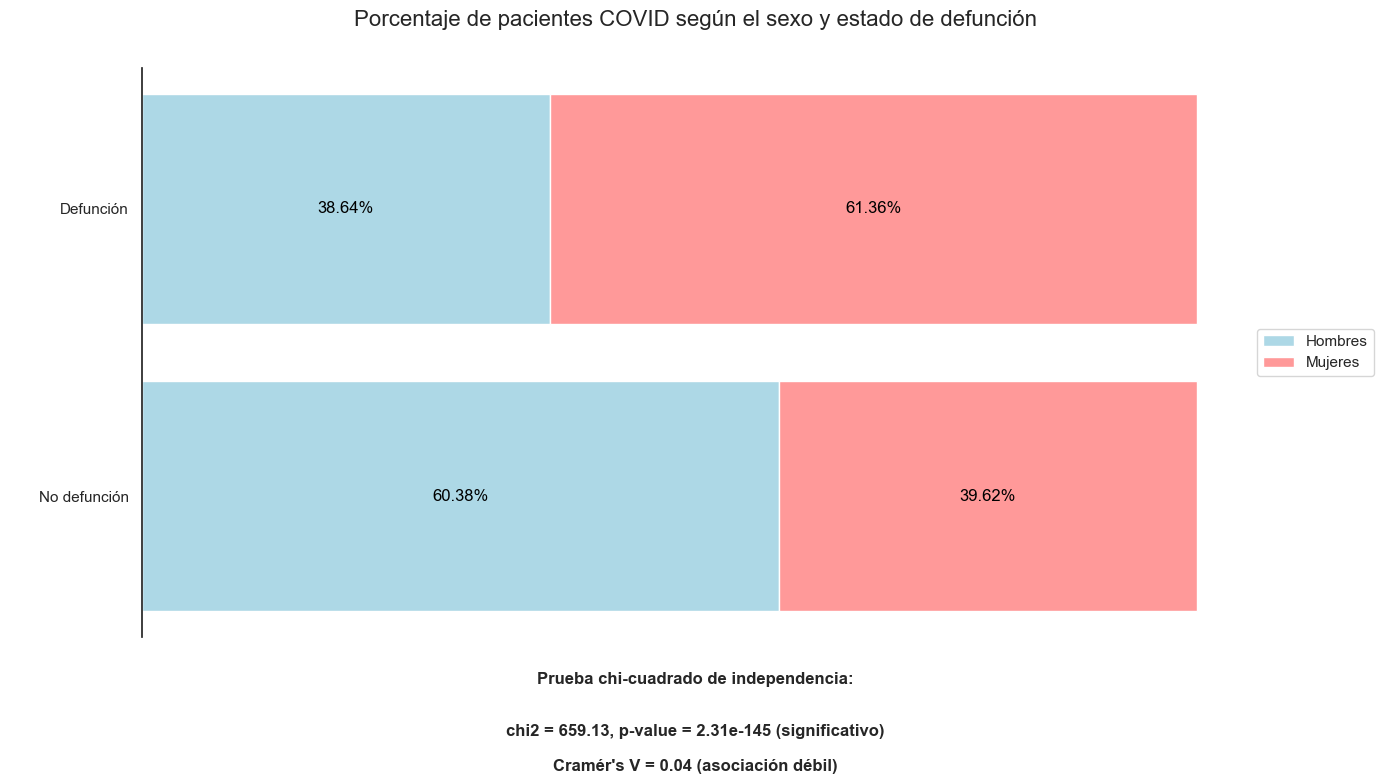

In [34]:
# Calcular el porcentaje de personas fallecidas y no fallecidas por sexo
fallecidos_hombres = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['SEXO'] == 1)])
fallecidos_mujeres = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['SEXO'] == 2)])
no_fallecidos_hombres = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['SEXO'] == 1)])
no_fallecidos_mujeres = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['SEXO'] == 2)])

# Porcentajes
porcentaje_fallecidos_hombres = fallecidos_hombres / (fallecidos_hombres + fallecidos_mujeres) * 100
porcentaje_fallecidos_mujeres = fallecidos_mujeres / (fallecidos_hombres + fallecidos_mujeres) * 100
porcentaje_no_fallecidos_hombres = no_fallecidos_hombres / (no_fallecidos_hombres + no_fallecidos_mujeres) * 100
porcentaje_no_fallecidos_mujeres = no_fallecidos_mujeres / (no_fallecidos_hombres + no_fallecidos_mujeres) * 100

# Datos para la gráfica
labels = ['No defunción', 'Defunción']
hombres = [porcentaje_no_fallecidos_hombres, porcentaje_fallecidos_hombres]
mujeres = [porcentaje_no_fallecidos_mujeres, porcentaje_fallecidos_mujeres]

# Crear tabla de contingencia para la prueba de chi-cuadrado
contingency_table = pd.crosstab(df_covid['SEXO'], df_covid['DEFUNCION'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cálculo del tamaño del efecto
cramers_v_value = cramers_v(contingency_table)

# Definir tipo de asociación
if cramers_v_value >= 0.5:
    asociacion = 'asociación muy fuerte'
elif cramers_v_value >= 0.3:
    asociacion = 'asociación fuerte'
elif cramers_v_value >= 0.1:
    asociacion = 'asociación moderada'
else: 
    asociacion = 'asociación débil'

# Crear la gráfica de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(14, 8))

# Crear barras apiladas horizontales
bar1 = ax.barh(labels, hombres, color='#add8e6', label='Hombres')
bar2 = ax.barh(labels, mujeres, left=hombres, color='#ff9999', label='Mujeres')

# Añadir los porcentajes encima de cada barra
for i, (rect1, rect2) in enumerate(zip(bar1, bar2)):
    width1 = rect1.get_width()
    width2 = rect2.get_width()
    ax.text(width1 / 2, rect1.get_y() + rect1.get_height() / 2, f'{width1:.2f}%', ha='center', va='center', color='black')
    ax.text(width1 + width2 / 2, rect2.get_y() + rect2.get_height() / 2, f'{width2:.2f}%', ha='center', va='center', color='black')

# Añadir títulos y etiquetas
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID según el sexo y estado de defunción', pad=30, fontsize=16)
ax.legend(labels=['Hombres', 'Mujeres'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir resultado de la prueba de hipótesis y el tamaño del efecto
if p < 0.05:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
else:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**¿Cómo influye ser indígena o hablar una lengua indígena en el porcentaje de fallecimientos de pacientes COVID positivos?**

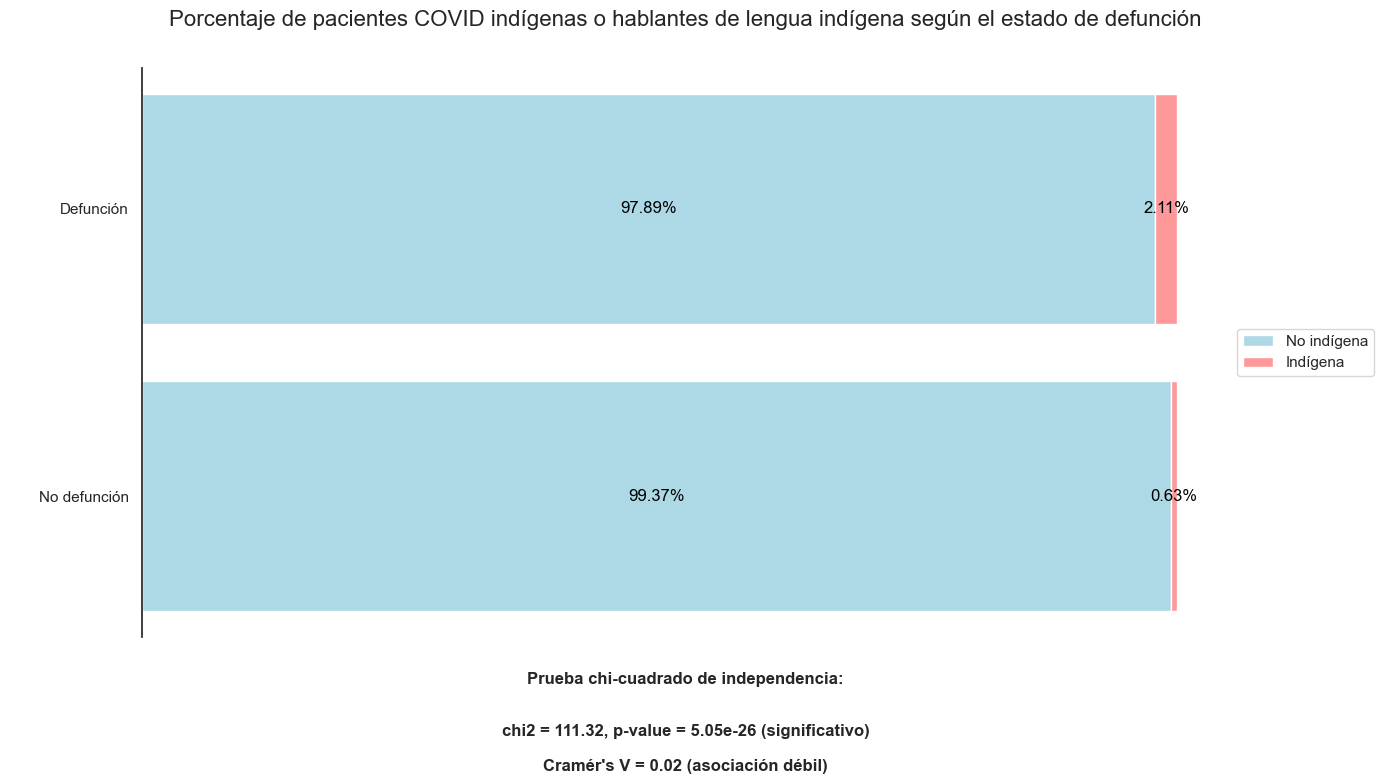

In [35]:
# Copia de nuestro dataframe con pacientes COVID positivos
covid_positivos = df_covid.copy()

# Crear una nueva columna 'CATEGORIA' para identificar si el paciente es indígena o no
covid_positivos['CATEGORIA'] = covid_positivos.apply(lambda row: 'Indígena' if row['HABLA_LENGUA_INDIG'] == 1 or row['INDIGENA'] == 1 else 'No indígena', axis=1)

# Calcular el porcentaje de personas fallecidas y no fallecidas por categoría
fallecidos_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'Indígena')])
fallecidos_no_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'No indígena')])
no_fallecidos_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'Indígena')])
no_fallecidos_no_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'No indígena')])

# Porcentajes
porcentaje_fallecidos_indigena = fallecidos_indigena / (fallecidos_indigena + fallecidos_no_indigena) * 100
porcentaje_fallecidos_no_indigena = fallecidos_no_indigena / (fallecidos_indigena + fallecidos_no_indigena) * 100
porcentaje_no_fallecidos_indigena = no_fallecidos_indigena / (no_fallecidos_indigena + no_fallecidos_no_indigena) * 100
porcentaje_no_fallecidos_no_indigena = no_fallecidos_no_indigena / (no_fallecidos_indigena + no_fallecidos_no_indigena) * 100

# Datos para la gráfica
labels = ['No defunción', 'Defunción']
indigena = [porcentaje_no_fallecidos_indigena, porcentaje_fallecidos_indigena]
no_indigena = [porcentaje_no_fallecidos_no_indigena, porcentaje_fallecidos_no_indigena]

# Crear tabla de contingencia para la prueba de chi-cuadrado
contingency_table = pd.crosstab(covid_positivos['CATEGORIA'], covid_positivos['DEFUNCION'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cálculo del tamaño del efecto
cramers_v_value = cramers_v(contingency_table)

# Definir tipo de asociación
if cramers_v_value >= 0.5:
    asociacion = 'asociación muy fuerte'
elif cramers_v_value >= 0.3:
    asociacion = 'asociación fuerte'
elif cramers_v_value >= 0.1:
    asociacion = 'asociación moderada'
else: 
    asociacion = 'asociación débil'

# Crear la gráfica de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(14, 8))

# Crear barras apiladas horizontales
bar1 = ax.barh(labels, no_indigena, color='#add8e6', label='No indígena')
bar2 = ax.barh(labels, indigena, left=no_indigena, color='#ff9999', label='Indígena')

# Añadir los porcentajes encima de cada barra
for i, (rect1, rect2) in enumerate(zip(bar1, bar2)):
    width1 = rect1.get_width()
    width2 = rect2.get_width()
    ax.text(width1 / 2, rect1.get_y() + rect1.get_height() / 2, f'{width1:.2f}%', ha='center', va='center', color='black')
    ax.text(width1 + width2 / 2, rect2.get_y() + rect2.get_height() / 2, f'{width2:.2f}%', ha='center', va='center', color='black')

# Añadir títulos y etiquetas
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID indígenas o hablantes de lengua indígena según el estado de defunción', pad=30, fontsize=16)
ax.legend(labels=['No indígena', 'Indígena'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir resultado de la prueba de hipótesis y el tamaño del efecto
if p < 0.05:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
else:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**¿Cómo influye ser migrante en el porcentaje de fallecimientos de pacientes COVID positivos?**

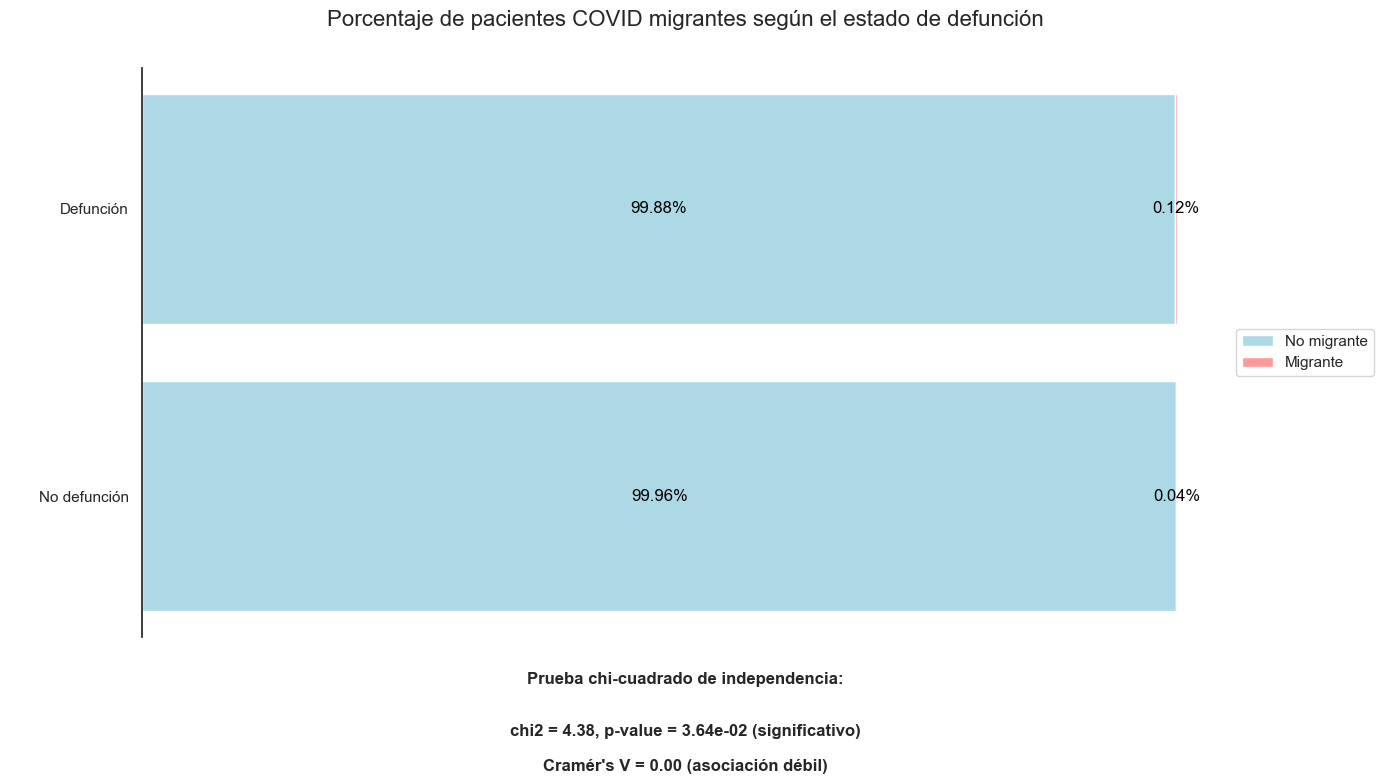

In [36]:
# Copia de nuestro dataframe con pacientes COVID positivos
covid_positivos = df_covid.copy()

# Crear una nueva columna 'CATEGORIA' para identificar si el paciente es migrante o no
covid_positivos['CATEGORIA'] = covid_positivos.apply(lambda row: 'Migrante' if row['MIGRANTE'] == 1 else 'No migrante', axis=1)

# Calcular el porcentaje de personas fallecidas y no fallecidas por categoría
fallecidos_migrante = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'Migrante')])
fallecidos_no_migrante = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'No migrante')])
no_fallecidos_migrante = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'Migrante')])
no_fallecidos_no_migrante = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'No migrante')])

# Porcentajes
porcentaje_fallecidos_migrante = fallecidos_migrante / (fallecidos_migrante + fallecidos_no_migrante) * 100
porcentaje_fallecidos_no_migrante = fallecidos_no_migrante / (fallecidos_migrante + fallecidos_no_migrante) * 100
porcentaje_no_fallecidos_migrante = no_fallecidos_migrante / (no_fallecidos_migrante + no_fallecidos_no_migrante) * 100
porcentaje_no_fallecidos_no_migrante = no_fallecidos_no_migrante / (no_fallecidos_migrante + no_fallecidos_no_migrante) * 100

# Datos para la gráfica
labels = ['No defunción', 'Defunción']
migrante = [porcentaje_no_fallecidos_migrante, porcentaje_fallecidos_migrante]
no_migrante = [porcentaje_no_fallecidos_no_migrante, porcentaje_fallecidos_no_migrante]

# Crear tabla de contingencia para la prueba de chi-cuadrado
contingency_table = pd.crosstab(covid_positivos['CATEGORIA'], covid_positivos['DEFUNCION'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cálculo del tamaño del efecto
cramers_v_value = cramers_v(contingency_table)

# Definir tipo de asociación
if cramers_v_value >= 0.5:
    asociacion = 'asociación muy fuerte'
elif cramers_v_value >= 0.3:
    asociacion = 'asociación fuerte'
elif cramers_v_value >= 0.1:
    asociacion = 'asociación moderada'
else: 
    asociacion = 'asociación débil'

# Crear la gráfica de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(14, 8))

# Crear barras apiladas horizontales
bar1 = ax.barh(labels, no_migrante, color='#add8e6', label='No migrante')
bar2 = ax.barh(labels, migrante, left=no_migrante, color='#ff9999', label='Migrante')

# Añadir los porcentajes encima de cada barra
for i, (rect1, rect2) in enumerate(zip(bar1, bar2)):
    width1 = rect1.get_width()
    width2 = rect2.get_width()
    ax.text(width1 / 2, rect1.get_y() + rect1.get_height() / 2, f'{width1:.2f}%', ha='center', va='center', color='black')
    ax.text(width1 + width2 / 2, rect2.get_y() + rect2.get_height() / 2, f'{width2:.2f}%', ha='center', va='center', color='black')

# Añadir títulos y etiquetas
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID migrantes según el estado de defunción', pad=30, fontsize=16)
ax.legend(labels=['No migrante', 'Migrante'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir resultado de la prueba de hipótesis y el tamaño del efecto
if p < 0.05:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
else:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Vicios y comorbilidades

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron presentaron tabaquismo?**

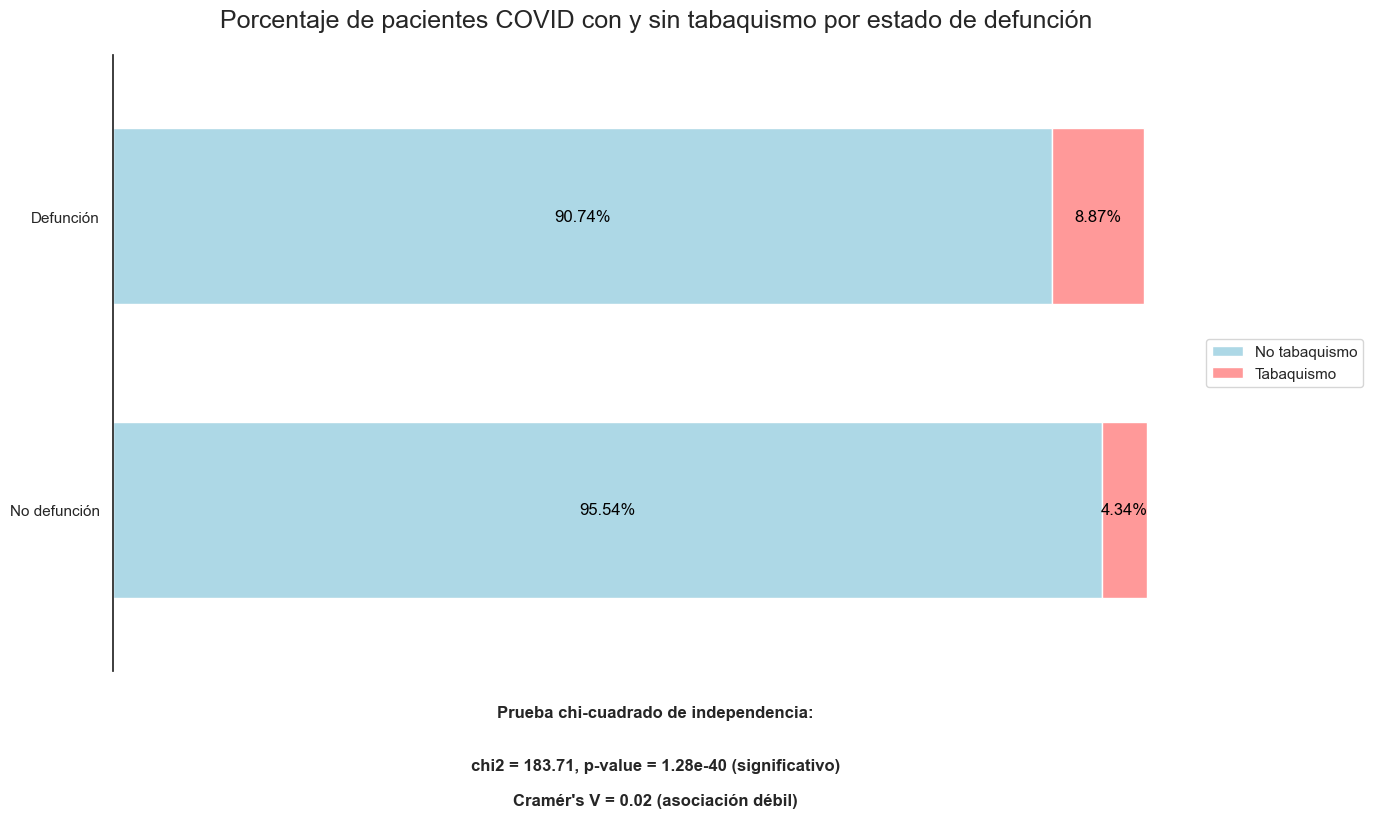

In [37]:
# Calcular proporciones
prop_no_fall_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['TABAQUISMO'] == 1)]) / N_COVID_NO_FALLECIDOS
prop_no_fall_no_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['TABAQUISMO'] == 2)]) / N_COVID_NO_FALLECIDOS

prop_fall_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['TABAQUISMO'] == 1)]) / N_COVID_FALLECIDOS
prop_fall_no_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['TABAQUISMO'] == 2)]) / N_COVID_FALLECIDOS

# Preparar los datos para la gráfica
data = {
    'Estado': ['No defunción', 'Defunción'],
    'No tabaquismo': [prop_no_fall_no_tabaquismo, prop_fall_no_tabaquismo],
    'Tabaquismo': [prop_no_fall_tabaquismo, prop_fall_tabaquismo]
}

df_plot = pd.DataFrame(data)

# Crear tabla de contingencia para la prueba de chi-cuadrado
contingency_table = pd.crosstab(df_covid['TABAQUISMO'], df_covid['DEFUNCION'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cálculo del tamaño del efecto
cramers_v_value = cramers_v(contingency_table)

# Definir tipo de asociación
if cramers_v_value >= 0.5:
    asociacion = 'asociación muy fuerte'
elif cramers_v_value >= 0.3:
    asociacion = 'asociación fuerte'
elif cramers_v_value >= 0.1:
    asociacion = 'asociación moderada'
else: 
    asociacion = 'asociación débil'

# Crear la gráfica con seaborn
fig, ax = plt.subplots(figsize=(14, 8))  # Incrementar el tamaño de la gráfica
df_plot.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=ax)

# Añadir algunas etiquetas, título y etiquetas de ejes personalizadas
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Porcentaje de pacientes COVID con y sin tabaquismo por estado de defunción', pad=20, fontsize=18)
ax.legend(labels=['No tabaquismo', 'Tabaquismo'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir etiquetas de datos sobre cada barra
for i, (no_tabaquismo, tabaquismo) in enumerate(zip(df_plot['No tabaquismo'], df_plot['Tabaquismo'])):
    ax.text(no_tabaquismo / 2, i, f'{no_tabaquismo:.2%}', ha='center', va='center', color='black')
    ax.text(no_tabaquismo + tabaquismo / 2, i, f'{tabaquismo:.2%}', ha='center', va='center', color='black')

# Añadir resultado de la prueba de hipótesis y el tamaño del efecto
if p < 0.05:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
else:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron presentaron alguna comorbilidad?**

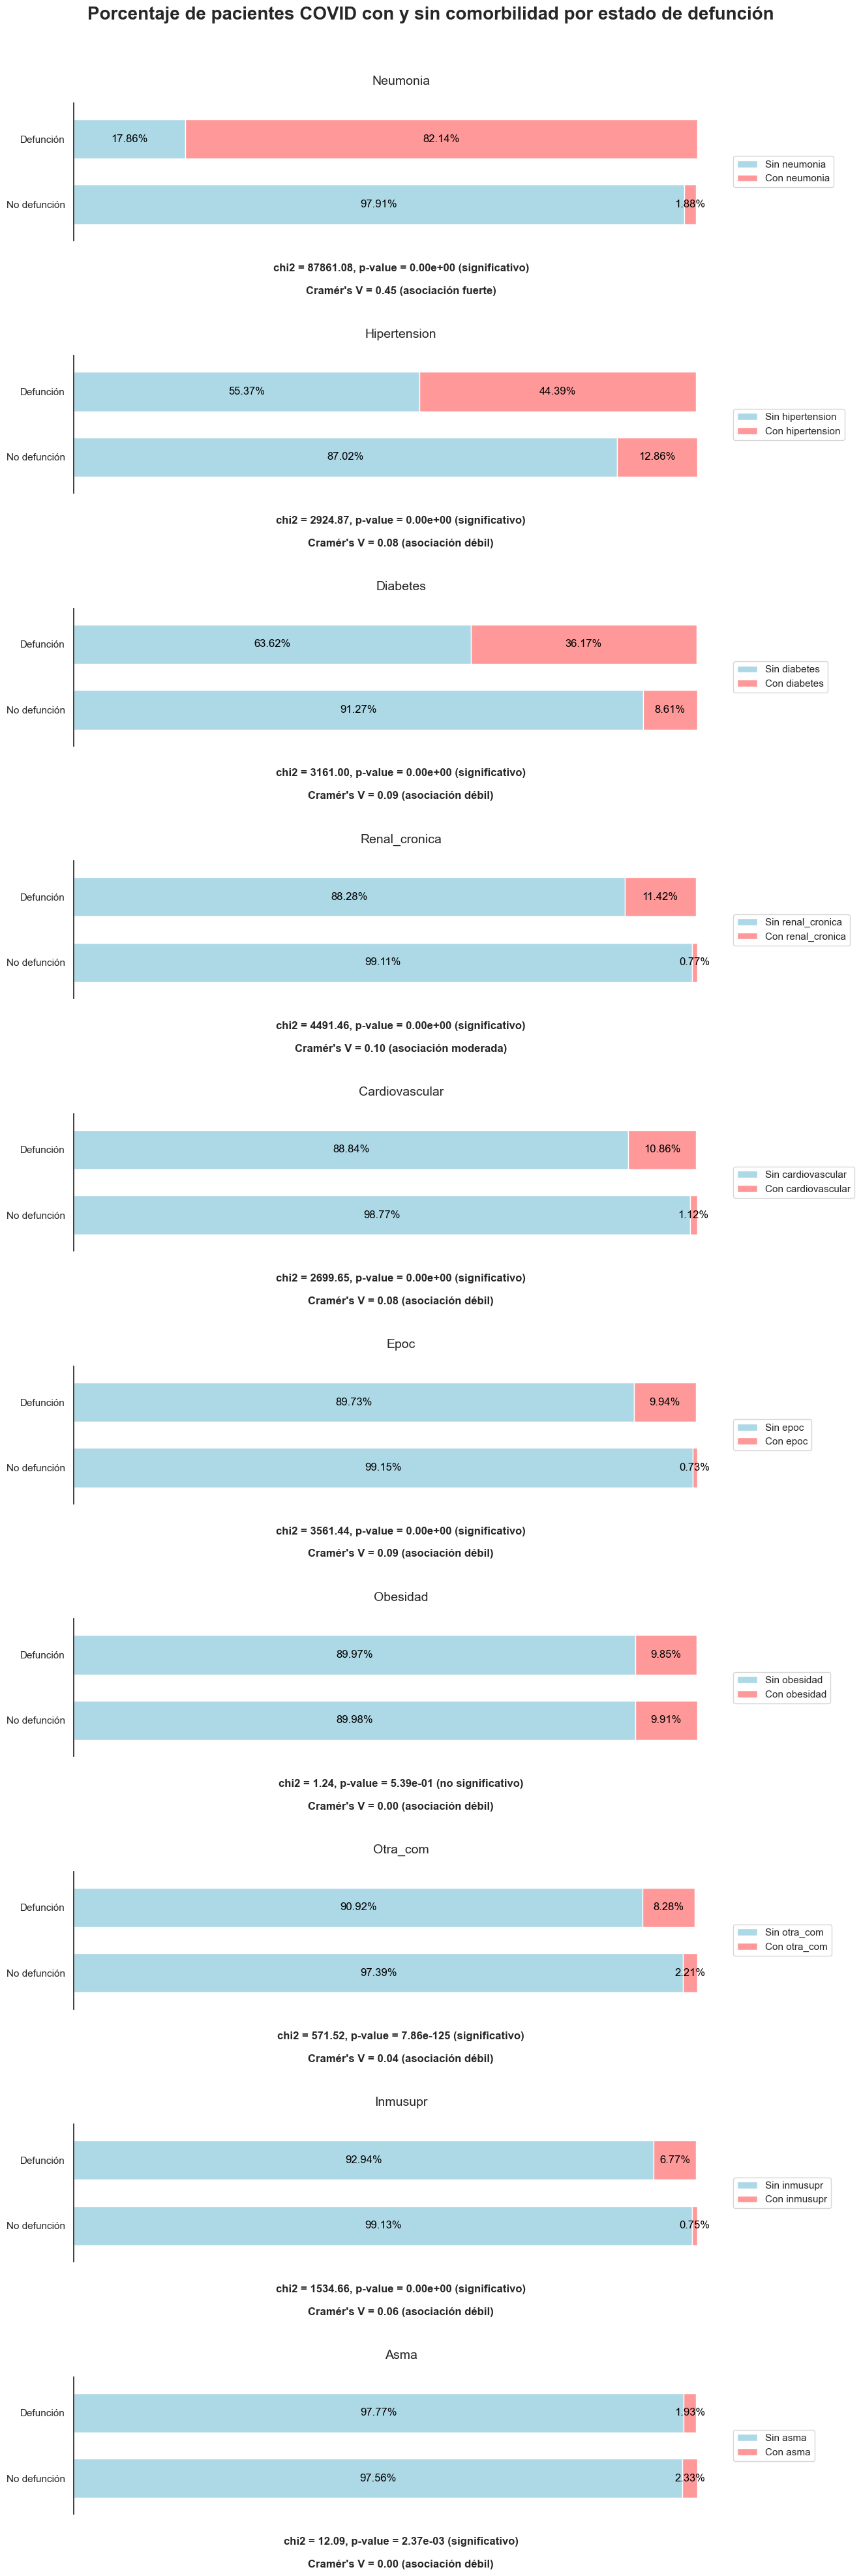

In [38]:
# Calcular los valores de defunción con comorbilidad para ordenar
defuncion_con_valores = {}
for var in COMORBILIDADES:
    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    defuncion_con_valores[var] = prop_fall_con

# Ordenar las variables en base a los valores calculados
variables_ordenadas = sorted(defuncion_con_valores, key=defuncion_con_valores.get, reverse=True)

# Crear figura y subgráficas
fig, axs = plt.subplots(nrows=len(COMORBILIDADES), ncols=1, figsize=(14, 4 * len(COMORBILIDADES)))
fig.suptitle('Porcentaje de pacientes COVID con y sin comorbilidad por estado de defunción', fontsize=20, fontweight="bold", y=0.995)

for i, var in enumerate(variables_ordenadas):
    # Calcular las proporciones por grupo
    prop_no_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid[var] == 1)]) / N_COVID_NO_FALLECIDOS
    prop_no_fall_sin = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid[var] == 2)]) / N_COVID_NO_FALLECIDOS

    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    prop_fall_sin = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 2)]) / N_COVID_FALLECIDOS

    # Preparar los datos para la gráfica
    data = {
        'Estado': ['No defunción', 'Defunción'],
        f'Sin {var.lower()}': [prop_no_fall_sin, prop_fall_sin],
        f'Con {var.lower()}': [prop_no_fall_con, prop_fall_con]
    }

    df_plot = pd.DataFrame(data)

    # Crear tabla de contingencia para la prueba de chi-cuadrado
    contingency_table = pd.crosstab(df_covid[var], df_covid['DEFUNCION'])

    # Realizar la prueba de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Cálculo del tamaño del efecto
    cramers_v_value = cramers_v(contingency_table)

    # Definir tipo de asociación
    if cramers_v_value >= 0.5:
        asociacion = 'asociación muy fuerte'
    elif cramers_v_value >= 0.3:
        asociacion = 'asociación fuerte'
    elif cramers_v_value >= 0.1:
        asociacion = 'asociación moderada'
    else: 
        asociacion = 'asociación débil'

    # Crear la gráfica con seaborn
    df_plot.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=axs[i])

    # Añadir algunas etiquetas, título y etiquetas de ejes personalizadas
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(var.capitalize(), pad=20, fontsize=14)
    axs[i].legend(labels=[f'Sin {var.lower()}', f'Con {var.lower()}'], title='', loc='center left', bbox_to_anchor=(1, 0.5))

    # Añadir etiquetas de datos sobre cada barra
    for j, (sin_var, con_var) in enumerate(zip(df_plot[f'Sin {var.lower()}'], df_plot[f'Con {var.lower()}'])):
        axs[i].text(sin_var / 2, j, f'{sin_var:.2%}', ha='center', va='center', color='black')
        axs[i].text(sin_var + con_var / 2, j, f'{con_var:.2%}', ha='center', va='center', color='black')

    # Añadir resultado de la prueba de hipótesis y el tamaño del efecto
    if p < 0.05:
        axs[i].set_xlabel(f"chi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
    else:
        axs[i].set_xlabel(f"chi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

    # Desactivar las marcas en el eje x
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # Desactivar las marcas en el eje y
    axs[i].tick_params(axis='y', which='both', left=False)

    # Mantener solo el borde izquierdo
    axs[i].spines['left'].set_visible(True)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron presentaron tabaquismo y alguna comorbilidad?**

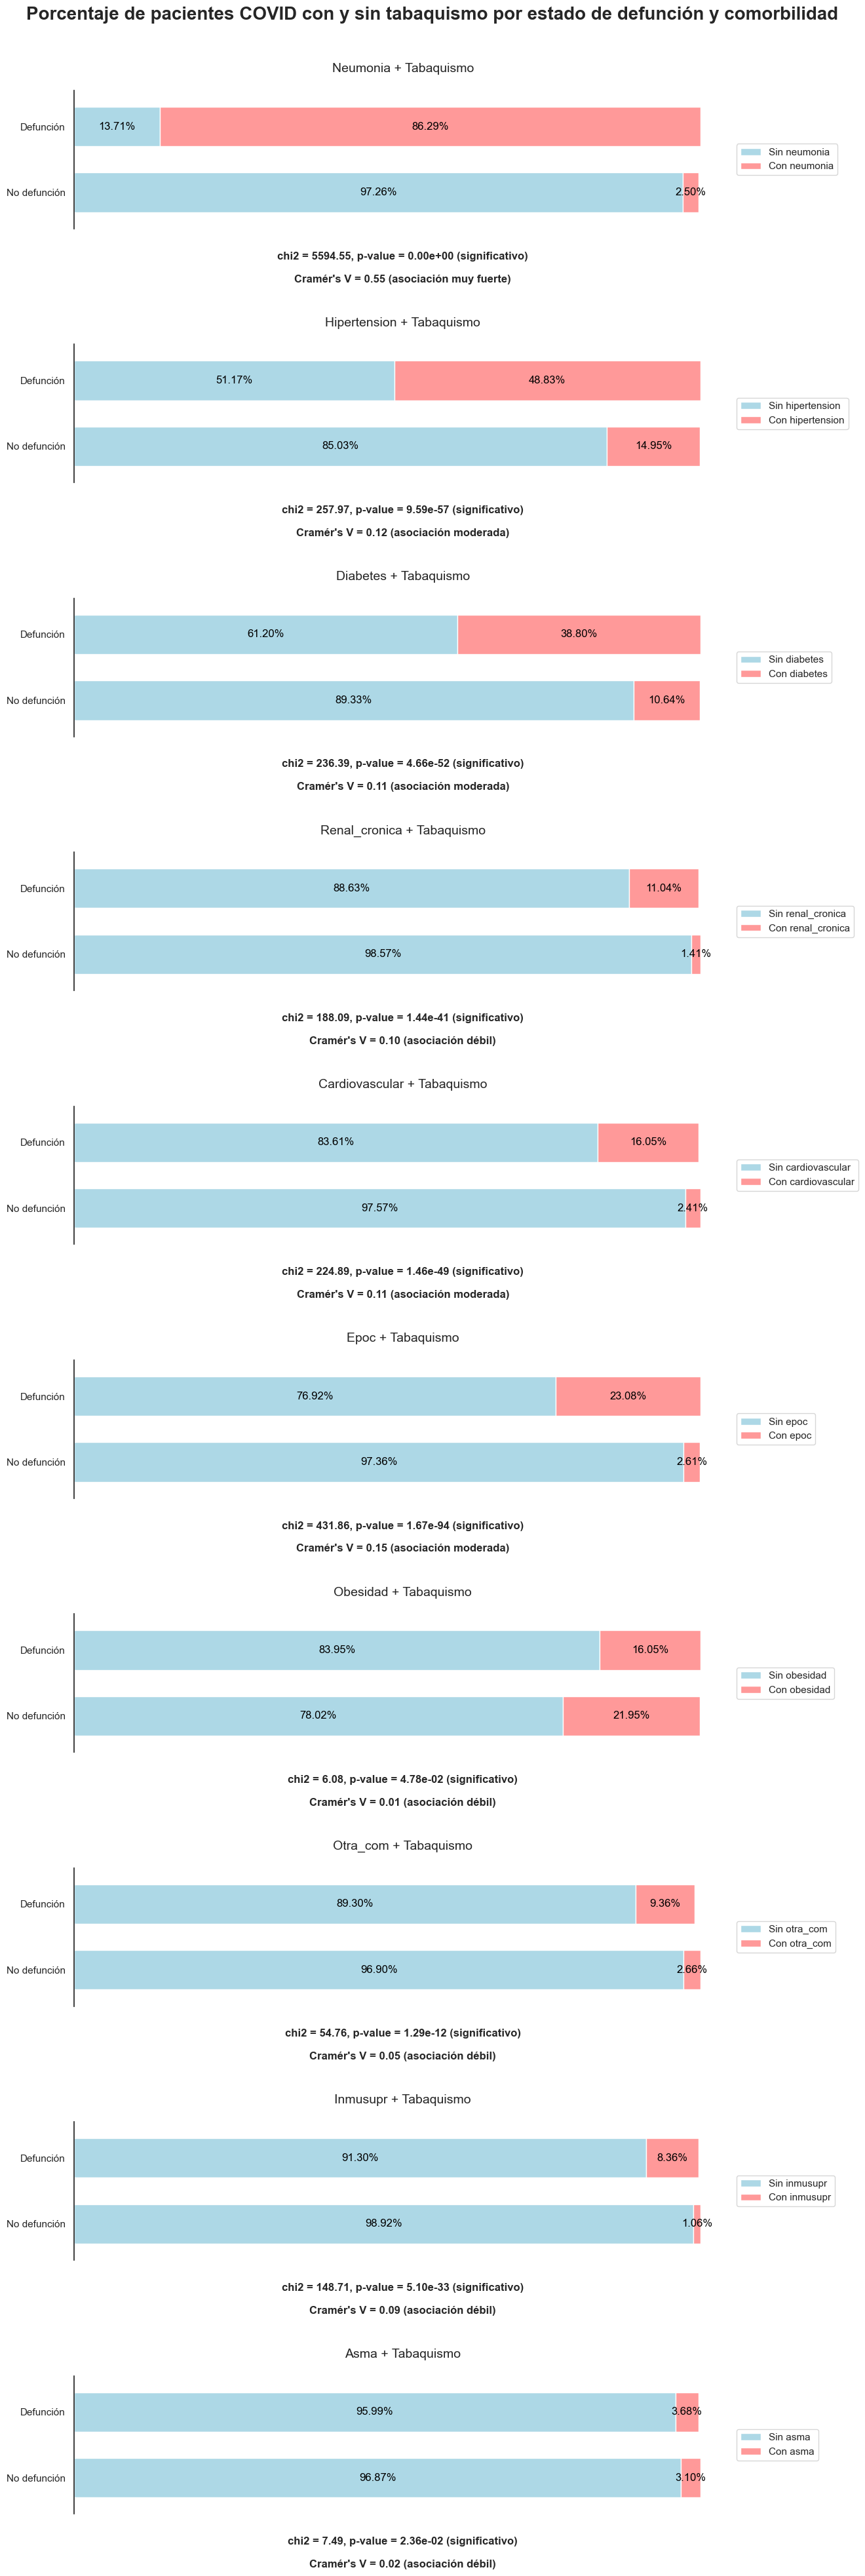

In [39]:
# Calcular los valores de defunción con comorbilidad para ordenar
defuncion_con_valores = {}
for var in COMORBILIDADES:
    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    defuncion_con_valores[var] = prop_fall_con

# Ordenar las variables en base a los valores calculados
variables_ordenadas = sorted(defuncion_con_valores, key=defuncion_con_valores.get, reverse=True)

# Crear figura y subgráficas
fig, axs = plt.subplots(nrows=len(COMORBILIDADES), ncols=1, figsize=(14, 4 * len(COMORBILIDADES)))
fig.suptitle('Porcentaje de pacientes COVID con y sin tabaquismo por estado de defunción y comorbilidad', fontsize=20, fontweight="bold", y=0.99)

for i, var in enumerate(variables_ordenadas):
    # Gráficas con filtro de tabaquismo
    df_covid_tabaquismo = df_covid[df_covid['TABAQUISMO'] == 1]
    total_no_fallecidos_tabaquismo = len(df_covid_tabaquismo[df_covid_tabaquismo['DEFUNCION'] == 2])
    total_fallecidos_tabaquismo = len(df_covid_tabaquismo[df_covid_tabaquismo['DEFUNCION'] == 1])

    prop_no_fall_con_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 2) & (df_covid_tabaquismo[var] == 1)]) / total_no_fallecidos_tabaquismo
    prop_no_fall_sin_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 2) & (df_covid_tabaquismo[var] == 2)]) / total_no_fallecidos_tabaquismo

    prop_fall_con_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 1) & (df_covid_tabaquismo[var] == 1)]) / total_fallecidos_tabaquismo
    prop_fall_sin_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 1) & (df_covid_tabaquismo[var] == 2)]) / total_fallecidos_tabaquismo

    data_tabaquismo = {
        'Estado': ['No defunción', 'Defunción'],
        f'Sin {var.lower()}': [prop_no_fall_sin_tabaquismo, prop_fall_sin_tabaquismo],
        f'Con {var.lower()}': [prop_no_fall_con_tabaquismo, prop_fall_con_tabaquismo]
    }

    df_plot_tabaquismo = pd.DataFrame(data_tabaquismo)

    contingency_table_tabaquismo = pd.crosstab(df_covid_tabaquismo[var], df_covid_tabaquismo['DEFUNCION'])

    # Realizar la prueba de chi-cuadrado para tabaquismo
    chi2_tabaquismo, p_tabaquismo, dof_tabaquismo, expected_tabaquismo = chi2_contingency(contingency_table_tabaquismo)

    # Cálculo del tamaño del efecto para tabaquismo
    cramers_v_value_tabaquismo = cramers_v(contingency_table_tabaquismo)

    # Definir tipo de asociación para tabaquismo
    if cramers_v_value_tabaquismo >= 0.5:
        asociacion_tabaquismo = 'asociación muy fuerte'
    elif cramers_v_value_tabaquismo >= 0.3:
        asociacion_tabaquismo = 'asociación fuerte'
    elif cramers_v_value_tabaquismo >= 0.1:
        asociacion_tabaquismo = 'asociación moderada'
    else: 
        asociacion_tabaquismo = 'asociación débil'

    df_plot_tabaquismo.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(f'{var.capitalize()} + Tabaquismo', pad=20, fontsize=14)
    axs[i].legend(labels=[f'Sin {var.lower()}', f'Con {var.lower()}'], title='', loc='center left', bbox_to_anchor=(1, 0.5))

    for j, (sin_var, con_var) in enumerate(zip(df_plot_tabaquismo[f'Sin {var.lower()}'], df_plot_tabaquismo[f'Con {var.lower()}'])):
        axs[i].text(sin_var / 2, j, f'{sin_var:.2%}', ha='center', va='center', color='black')
        axs[i].text(sin_var + con_var / 2, j, f'{con_var:.2%}', ha='center', va='center', color='black')

    if p_tabaquismo < 0.05:
        axs[i].set_xlabel(f"chi2 = {chi2_tabaquismo:.2f}, p-value = {p_tabaquismo:.2e} (significativo)\n\nCramér's V = {cramers_v_value_tabaquismo:.2f} ({asociacion_tabaquismo})", labelpad=25, fontweight='bold')
    else:
        axs[i].set_xlabel(f"chi2 = {chi2_tabaquismo:.2f}, p-value = {p_tabaquismo:.2e} (no significativo)\n\nCramér's V = {cramers_v_value_tabaquismo:.2f} ({asociacion_tabaquismo})", labelpad=25, fontweight='bold')

    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i].tick_params(axis='y', which='both', left=False)
    axs[i].spines['left'].set_visible(True)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()

### Intervención médica

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron estuvieron en la UCI?**

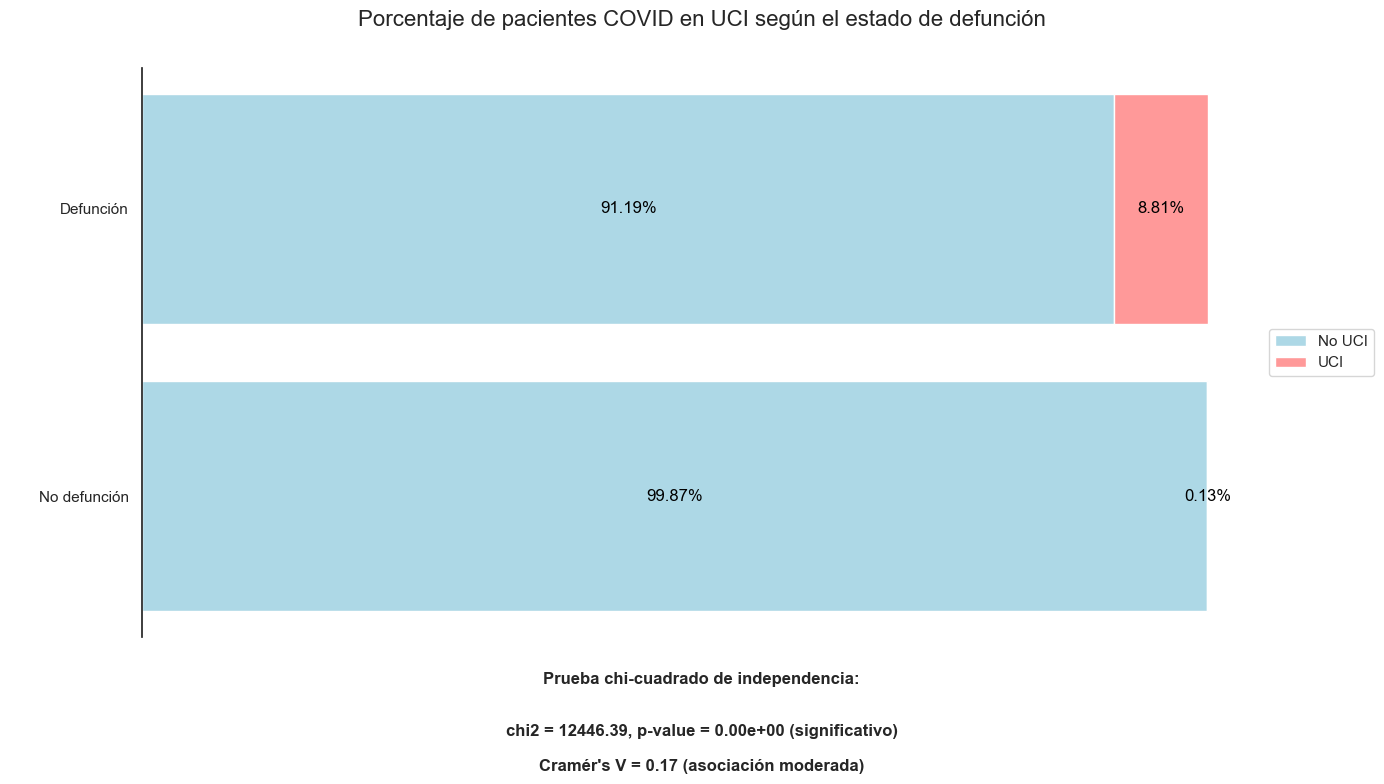

In [40]:
# Copia de nuestro dataframe con pacientes COVID positivos
covid_positivos = df_covid.copy()

# Crear una nueva columna 'CATEGORIA' para identificar si el paciente estuvo en UCI o no
covid_positivos['CATEGORIA'] = covid_positivos.apply(lambda row: 'UCI' if row['UCI'] == 1 else 'No UCI', axis=1)

# Calcular el porcentaje de personas fallecidas y no fallecidas por categoría
fallecidos_uci = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'UCI')])
fallecidos_no_uci = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'No UCI')])
no_fallecidos_uci = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'UCI')])
no_fallecidos_no_uci = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'No UCI')])

# Porcentajes
porcentaje_fallecidos_uci = fallecidos_uci / (fallecidos_uci + fallecidos_no_uci) * 100
porcentaje_fallecidos_no_uci = fallecidos_no_uci / (fallecidos_uci + fallecidos_no_uci) * 100
porcentaje_no_fallecidos_uci = no_fallecidos_uci / (no_fallecidos_uci + no_fallecidos_no_uci) * 100
porcentaje_no_fallecidos_no_uci = no_fallecidos_no_uci / (no_fallecidos_uci + no_fallecidos_no_uci) * 100

# Datos para la gráfica
labels = ['No defunción', 'Defunción']
uci = [porcentaje_no_fallecidos_uci, porcentaje_fallecidos_uci]
no_uci = [porcentaje_no_fallecidos_no_uci, porcentaje_fallecidos_no_uci]

# Crear tabla de contingencia para la prueba de chi-cuadrado
contingency_table = pd.crosstab(covid_positivos['CATEGORIA'], covid_positivos['DEFUNCION'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cálculo del tamaño del efecto
cramers_v_value = cramers_v(contingency_table)

# Definir tipo de asociación
if cramers_v_value >= 0.5:
    asociacion = 'asociación muy fuerte'
elif cramers_v_value >= 0.3:
    asociacion = 'asociación fuerte'
elif cramers_v_value >= 0.1:
    asociacion = 'asociación moderada'
else: 
    asociacion = 'asociación débil'

# Crear la gráfica de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(14, 8))

# Crear barras apiladas horizontales
bar1 = ax.barh(labels, no_uci, color='#add8e6', label='No UCI')
bar2 = ax.barh(labels, uci, left=no_uci, color='#ff9999', label='UCI')

# Añadir los porcentajes encima de cada barra
for i, (rect1, rect2) in enumerate(zip(bar1, bar2)):
    width1 = rect1.get_width()
    width2 = rect2.get_width()
    ax.text(width1 / 2, rect1.get_y() + rect1.get_height() / 2, f'{width1:.2f}%', ha='center', va='center', color='black')
    ax.text(width1 + width2 / 2, rect2.get_y() + rect2.get_height() / 2, f'{width2:.2f}%', ha='center', va='center', color='black')

# Añadir títulos y etiquetas
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID en UCI según el estado de defunción', pad=30, fontsize=16)
ax.legend(labels=['No UCI', 'UCI'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir resultado de la prueba de hipótesis y el tamaño del efecto
if p < 0.05:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
else:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron estuvieron intubados?**

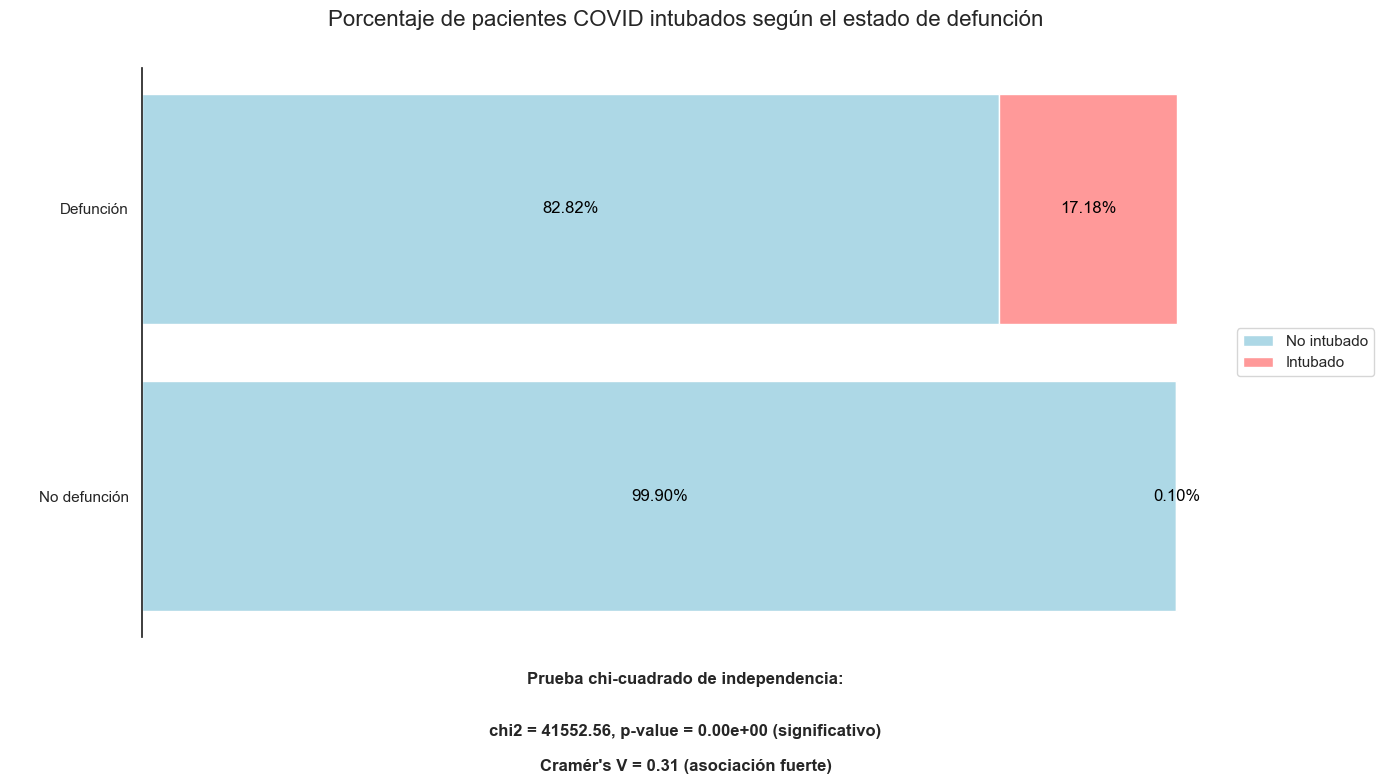

In [41]:
# Copia de nuestro dataframe con pacientes COVID positivos
covid_positivos = df_covid.copy()

# Crear una nueva columna 'CATEGORIA' para identificar si el paciente fue intubado o no
covid_positivos['CATEGORIA'] = covid_positivos.apply(lambda row: 'Intubado' if row['INTUBADO'] == 1 else 'No intubado', axis=1)

# Calcular el porcentaje de personas fallecidas y no fallecidas por categoría
fallecidos_intubado = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'Intubado')])
fallecidos_no_intubado = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'No intubado')])
no_fallecidos_intubado = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'Intubado')])
no_fallecidos_no_intubado = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'No intubado')])

# Porcentajes
porcentaje_fallecidos_intubado = fallecidos_intubado / (fallecidos_intubado + fallecidos_no_intubado) * 100
porcentaje_fallecidos_no_intubado = fallecidos_no_intubado / (fallecidos_intubado + fallecidos_no_intubado) * 100
porcentaje_no_fallecidos_intubado = no_fallecidos_intubado / (no_fallecidos_intubado + no_fallecidos_no_intubado) * 100
porcentaje_no_fallecidos_no_intubado = no_fallecidos_no_intubado / (no_fallecidos_intubado + no_fallecidos_no_intubado) * 100

# Datos para la gráfica
labels = ['No defunción', 'Defunción']
intubado = [porcentaje_no_fallecidos_intubado, porcentaje_fallecidos_intubado]
no_intubado = [porcentaje_no_fallecidos_no_intubado, porcentaje_fallecidos_no_intubado]

# Crear tabla de contingencia para la prueba de chi-cuadrado
contingency_table = pd.crosstab(covid_positivos['CATEGORIA'], covid_positivos['DEFUNCION'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cálculo del tamaño del efecto
cramers_v_value = cramers_v(contingency_table)

# Definir tipo de asociación
if cramers_v_value >= 0.5:
    asociacion = 'asociación muy fuerte'
elif cramers_v_value >= 0.3:
    asociacion = 'asociación fuerte'
elif cramers_v_value >= 0.1:
    asociacion = 'asociación moderada'
else: 
    asociacion = 'asociación débil'

# Crear la gráfica de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(14, 8))

# Crear barras apiladas horizontales
bar1 = ax.barh(labels, no_intubado, color='#add8e6', label='No intubado')
bar2 = ax.barh(labels, intubado, left=no_intubado, color='#ff9999', label='Intubado')

# Añadir los porcentajes encima de cada barra
for i, (rect1, rect2) in enumerate(zip(bar1, bar2)):
    width1 = rect1.get_width()
    width2 = rect2.get_width()
    ax.text(width1 / 2, rect1.get_y() + rect1.get_height() / 2, f'{width1:.2f}%', ha='center', va='center', color='black')
    ax.text(width1 + width2 / 2, rect2.get_y() + rect2.get_height() / 2, f'{width2:.2f}%', ha='center', va='center', color='black')

# Añadir títulos y etiquetas
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID intubados según el estado de defunción', pad=30, fontsize=16)
ax.legend(labels=['No intubado', 'Intubado'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir resultado de la prueba de hipótesis y el tamaño del efecto
if p < 0.05:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')
else:
    ax.set_xlabel(f"Prueba chi-cuadrado de independencia:\n\n\nchi2 = {chi2:.2f}, p-value = {p:.2e} (no significativo)\n\nCramér's V = {cramers_v_value:.2f} ({asociacion})", labelpad=25, fontweight='bold')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()